# Librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from math import pi
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.graph_objects as go

In [73]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

# Constantes

In [2]:
produccion_cocaina = {
    # Rendimientos por hectárea (toneladas/ha/año)
    "RENDIMIENTO_HOJAS_COLOMBIA": (4.6, 6.4),  # (4-6 cosechas)
    "RENDIMIENTO_HOJAS_PERU": (2.5, 4.0),      # (3-5 cosechas)
    "RENDIMIENTO_HOJAS_BOLIVIA": (1.5, 3.0),   # (3 cosechas)
    
    # Coeficientes de conversión
    "HOJAS_A_PASTA_BASE": (300, 400),           # kg hojas por kg pasta base
    "PASTA_BASE_A_CLORHIDRATO": (2.5, 3.0),     # kg pasta base por kg clorhidrato
    
    # Producción potencial 2022 (toneladas hoja)
    "PRODUCCION_POTENCIAL_COLOMBIA_2022": 8_000_000,  
    "PRODUCCION_POTENCIAL_PERU_2022": 2_000_000,      
    "PRODUCCION_POTENCIAL_BOLIVIA_2022": 90_000,      
}


produccion_opioides = {
    # Rendimiento de opio (kg/ha)
    "RENDIMIENTO_OPIO_AFGANISTAN": 32,
    "RENDIMIENTO_OPIO_MYANMAR": 14,
    "RENDIMIENTO_OPIO_LAOS": 6.5,
    "RENDIMIENTO_OPIO_MEXICO": 20.5,
    "RENDIMIENTO_OPIO_COLOMBIA": (20, 40),
    
    # Conversión a heroína
    "OPIO_A_MORFINA": 10,        # kg opio → 1 kg morfina
    "MORFINA_A_HEROINA": 0.9,    # kg morfina → 0.9 kg heroína
    
    # Producción México (DEA)
    "PRODUCCION_HEROINA_MEXICO_ANUAL": 90,  # toneladas
}


produccion_metanfetaminas = {
    # Laboratorios detectados (2022)
    "LABORATORIOS_EEUU_2022": 133,
    "LABORATORIOS_MEXICO_2022": 25,
    "LABORATORIOS_CHEQUIA_2022": 199,
    
    # Producción México (DEA)
    "PORCENTAJE_METANFETAMINAS_EEUU_MEXICO": 0.98,  # 98% del mercado
}

precios = {
    # Cocaína
    "PRECIO_COLOMBIA": 1_215.06,
    "PRECIO_PERU": 2_800.00,
    "PRECIO_BOLIVIA": 2_400.00,
    "PRECIO_ESPAÑA": 13_240.00,
    "PRECIO_EEUU": 35_500.00,
    
    # Heroína
    "PRECIO_PAKISTAN": 2_586.05,
    "PRECIO_INDIA": 191_331.41,
    "PRECIO_ESTADOS_UNIDOS_HEROINA": 35_500.00,
    
    # Metanfetaminas
    "PRECIO_MEXICO": 4_815.00,
    "PRECIO_EEUU_METANFETAMINA": 10_500.00,
    
    # Cannabis
    "PRECIO_RUSIA": 28_789.46,
    "PRECIO_MADAGASCAR": 18.12,
}

consumo = {
    # Prevalencia global (2022)
    "CONSUMIDORES_GLOBALES_COCAINA": 23_000_000,
    "PRODUCCION_GLOBAL_COCAINA_PURA_2022": 2_757,  # toneladas
    
    # Pureza promedio
    "PUREZA_COCAINA_CALLE": 0.60,  # 60% promedio global
    
    # Consumo per cápita ajustado
    "CONSUMO_POR_CONSUMIDOR_ANUAL": 82.98,  # gramos/año (cocaína pura) --> (("PRODUCCION_GLOBAL_COCAINA_PURA_2022"*1000)/"CONSUMIDORES_GLOBALES_COCAINA")* ("PUREZA_COCAINA_CALLE")
}

otros_datos = {
    # Costos de prohibición (miles de millones USD)
    "COSTO_PROHIBICION_EEUU": 341_400,
    "COSTO_PROHIBICION_UE": 139_400,
    "COSTO_PROHIBICION_MEXICO": 34_500,
    
    # Lavado de dinero
    "PORCENTAJE_LAVADO_PIB": (0.02, 0.05),  # 2%-5% del PIB global
}

rutas_trafico = [
    ('Colombia', 'Costa Rica', 500.81),
    ('Costa Rica', 'Guatemala', 81.97),
    ('Guatemala', 'Mexico', 100.0),
    ('Mexico', 'United States of America', 198.97),
    ('Colombia', 'Brazil', 300.0),
    ('Brazil', 'Portugal', 1141.82),
    ('Brazil', 'Spain', 1517.49),
    ('Ecuador', 'Spain', 1947.63),
    ('Ecuador', 'Netherlands', 1906.66),
    ('Venezuela', 'Spain', 800.81),
    ('Argentina', 'Spain', 677.35),
    ('Paraguay', 'Spain', 555.59),
    ('Uruguay', 'Spain', 519.31),
    ('Portugal', 'France', 188.46),
    ('Spain', 'France', 121.47),
    ('France', 'Germany', 50.0),
    ('Germany', 'Austria', 20.04),
    ('Germany', 'Finland', 43.66),
    ('Netherlands', 'Germany', 30.0),
    ('Belgium', 'Germany', 25.0),
    ('Belgium', 'France', 15.0),
    ('Netherlands', 'Belgium', 10.0),
    ('Netherlands', 'Denmark', 5.0),
    ('Denmark', 'Norway', 3.0),
    ('Germany', 'Moldova', 43.66)
]

# Cultivo

In [212]:

data = {
    'País': ['Bolivia', 'Colombia', 'Peru', 'Afganistán', 'Myanmar','Laos', 'Mexico'],
    'Coca': [26000, 119794.83, 58499.21, None, None, None, None],
    'Opio': [None, 408.76, None, 187414.29, 43223.08, 4443.38, 20000]
}

df_cultivo = pd.DataFrame(data)

In [213]:
df_cultivo.head()

País       Coca       Opio
0     Bolivia   26000.00        NaN
1    Colombia  119794.83     408.76
2        Peru   58499.21        NaN
3  Afganistán        NaN  187414.29
4     Myanmar        NaN   43223.08

<Figure size 1000x600 with 0 Axes>

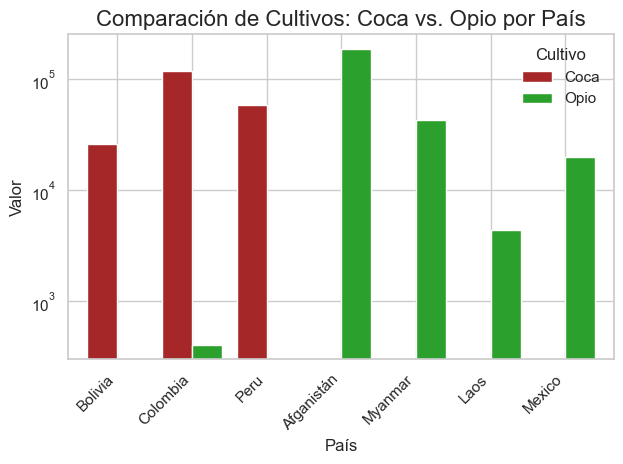

In [214]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))


df_cultivo.set_index('País')[['Coca', 'Opio']].plot(kind='bar', width=0.8, logy=True, color=['#a62728', '#2ca02c'])

plt.title('Comparación de Cultivos: Coca vs. Opio por País', fontsize=16)
plt.xlabel('País', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cultivo', labels=['Coca', 'Opio'])

plt.tight_layout()

In [215]:
total_coca = df_cultivo['Coca'].sum()
total_opio = df_cultivo['Opio'].sum()


df_cultivo_total = pd.DataFrame({'Cultivo': ['Coca', 'Opio'], 'Valor': [total_coca, total_opio]})
df_cultivo_total

Cultivo      Valor
0    Coca  204294.04
1    Opio  255489.51

In [216]:
produccion = {
    "RENDIMIENTO_HOJAS_COLOMBIA": (4.6, 6.4),
    "RENDIMIENTO_HOJAS_PERU": (2.5, 4.0),
    "RENDIMIENTO_HOJAS_BOLIVIA": (1.5, 3.0),
    "HOJAS_A_PASTA_BASE": (300, 400),
    "PASTA_BASE_A_CLORHIDRATO": (2.5, 3.0),
    "HECTAREAS_COLOMBIA_2022": 204_000,
    "HECTAREAS_PERU_2022": 61_800,
    "HECTAREAS_BOLIVIA_2022": 29_400,
    "PRODUCCION_POTENCIAL_COLOMBIA_2022": 8_000_000,
    "PRODUCCION_POTENCIAL_PERU_2022": 2_000_000,
    "PRODUCCION_POTENCIAL_BOLIVIA_2022": 90_000,
    "RENDIMIENTO_OPIO_AFGANISTAN": 32,
    "RENDIMIENTO_OPIO_MYANMAR": 14,
    "RENDIMIENTO_OPIO_LAOS": 6.5,
    "RENDIMIENTO_OPIO_MEXICO": 20.5,
    "RENDIMIENTO_OPIO_COLOMBIA": (20, 40),
    "OPIO_A_MORFINA": 10,
    "MORFINA_A_HEROINA": 0.9,
    "PRODUCCION_HEROINA_MEXICO_ANUAL": 90,
}

def calcular_produccion(df, params):
    resultados = []
    total_coca = 0
    total_opio = 0
    
    for _, row in df.iterrows():
        pais = row['País']
        reporte = {'País': pais}
        
        if pd.notnull(row['Coca']):
            if pais == 'Colombia':
                rmin = params["RENDIMIENTO_HOJAS_COLOMBIA"][0]
                rmax = params["RENDIMIENTO_HOJAS_COLOMBIA"][1]
                hmin = row['Coca'] * rmin
                hmax = row['Coca'] * rmax
                pmin = hmin / params['HOJAS_A_PASTA_BASE'][1]
                pmax = hmax / params['HOJAS_A_PASTA_BASE'][0]
                cmin = pmin / params['PASTA_BASE_A_CLORHIDRATO'][1]
                cmax = pmax / params['PASTA_BASE_A_CLORHIDRATO'][0]
                reporte['Cocaína (Tn)'] = f"{cmin:,.0f} - {cmax:,.0f}"
                total_coca += (cmin + cmax) / 2

            elif pais == 'Peru':
                rmin = params["RENDIMIENTO_HOJAS_PERU"][0]
                rmax = params["RENDIMIENTO_HOJAS_PERU"][1]
                hmin = row['Coca'] * rmin
                hmax = row['Coca'] * rmax
                pmin = hmin / params['HOJAS_A_PASTA_BASE'][1]
                pmax = hmax / params['HOJAS_A_PASTA_BASE'][0]
                cmin = pmin / params['PASTA_BASE_A_CLORHIDRATO'][1]
                cmax = pmax / params['PASTA_BASE_A_CLORHIDRATO'][0]
                reporte['Cocaína (Tn)'] = f"{cmin:,.0f} - {cmax:,.0f}"
                total_coca += (cmin + cmax) / 2

            elif pais == 'Bolivia':
                rmin = params["RENDIMIENTO_HOJAS_BOLIVIA"][0]
                rmax = params["RENDIMIENTO_HOJAS_BOLIVIA"][1]
                hmin = row['Coca'] * rmin
                hmax = row['Coca'] * rmax
                pmin = hmin / params['HOJAS_A_PASTA_BASE'][1]
                pmax = hmax / params['HOJAS_A_PASTA_BASE'][0]
                cmin = pmin / params['PASTA_BASE_A_CLORHIDRATO'][1]
                cmax = pmax / params['PASTA_BASE_A_CLORHIDRATO'][0]
                reporte['Cocaína (Tn)'] = f"{cmin:,.0f} - {cmax:,.0f}"
                total_coca += (cmin + cmax) / 2
        
        if pd.notnull(row['Opio']):
            if pais == 'Afganistán':
                op = row['Opio'] * params['RENDIMIENTO_OPIO_AFGANISTAN']
                mf = op / params['OPIO_A_MORFINA']
                hr = mf * params['MORFINA_A_HEROINA']
                reporte['Heroína (kg)'] = f"{hr:,.0f}"
                total_opio += hr

            elif pais == 'Myanmar':
                op = row['Opio'] * params['RENDIMIENTO_OPIO_MYANMAR']
                mf = op / params['OPIO_A_MORFINA']
                hr = mf * params['MORFINA_A_HEROINA']
                reporte['Heroína (kg)'] = f"{hr:,.0f}"
                total_opio += hr

            elif pais == 'Laos':
                op = row['Opio'] * params['RENDIMIENTO_OPIO_LAOS']
                mf = op / params['OPIO_A_MORFINA']
                hr = mf * params['MORFINA_A_HEROINA']
                reporte['Heroína (kg)'] = f"{hr:,.0f}"
                total_opio += hr

            elif pais == 'Mexico':
                op = row['Opio'] * params['RENDIMIENTO_OPIO_MEXICO']
                mf = op / params['OPIO_A_MORFINA']
                hr = mf * params['MORFINA_A_HEROINA']
                reporte['Heroína (kg)'] = f"{hr:,.0f}"
                total_opio += hr

            elif pais == 'Colombia':
                op = row['Opio'] * (params['RENDIMIENTO_OPIO_COLOMBIA'][0] + params['RENDIMIENTO_OPIO_COLOMBIA'][1]) / 2
                mf = op / params['OPIO_A_MORFINA']
                hr = mf * params['MORFINA_A_HEROINA']
                reporte['Heroína (kg)'] = f"{hr:,.0f}"
                total_opio += hr

        resultados.append(reporte)

    total_coca_toneladas = total_coca 
    total_opio_toneladas = total_opio / 1000

    df_resultados = pd.DataFrame(resultados)
    df_totales = pd.DataFrame({
        'Total Cocaína (toneladas)': [total_coca_toneladas],
        'Total Opio (toneladas)': [total_opio_toneladas]
    })

    return df_resultados, df_totales

df_produccion_final_pais, df_produccion_final_total = calcular_produccion(df_cultivo, produccion)

In [217]:
print("Producción estimada por País:")
df_produccion_final_pais

Producción estimada por País:


País Cocaína (Tn) Heroína (kg)
0     Bolivia     32 - 104          NaN
1    Colombia  459 - 1,022        1,104
2        Peru    122 - 312          NaN
3  Afganistán          NaN      539,753
4     Myanmar          NaN       54,461
5        Laos          NaN        2,599
6      Mexico          NaN       36,900

In [9]:
df_produccion_final_total = df_produccion_final_total.round(2)
print("Producción estimada total:")
df_produccion_final_total

Producción estimada total:


Total Cocaína (toneladas)  Total Opio (toneladas)
0                    1025.92                  634.82

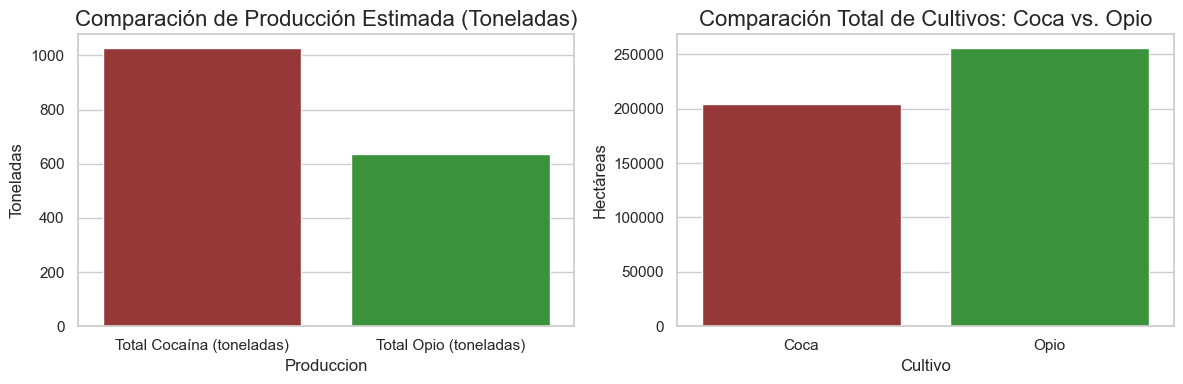

In [10]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x='Produccion', y='Valor', data=df_produccion_final_total.melt(var_name='Produccion', value_name='Valor'), palette=['#a62728', '#2ca02c'], ax=axes[0])
axes[0].set_title('Comparación de Producción Estimada (Toneladas)', fontsize=16)
axes[0].set_xlabel('Produccion', fontsize=12)
axes[0].set_ylabel('Toneladas', fontsize=12)

sns.barplot(x='Cultivo', y='Valor', data=df_cultivo_total, palette=['#a62728', '#2ca02c'], ax=axes[1])
axes[1].set_title('Comparación Total de Cultivos: Coca vs. Opio', fontsize=16)
axes[1].set_xlabel('Cultivo', fontsize=12)
axes[1].set_ylabel('Hectáreas', fontsize=12)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Produccion

In [11]:
df_produccion = pd.read_csv('../data/produccion.csv')

In [12]:
df_produccion.head()

País  Cocaína Categoría_Cocaína  Opioides Categoría_Opioides  \
0   Alemania      1.0          MUY BAJA       1.0           MUY BAJA   
1  Argentina    287.0              ALTA       1.0           MUY BAJA   
2  Australia     10.0              BAJA       6.0               BAJA   
3    Austria      NaN               NaN       NaN                NaN   
4    Belgica     22.0             MEDIA       2.0           MUY BAJA   

   Metanfetaminas Categoría_Metanfetaminas  
0            38.0                     ALTA  
1             4.0                     BAJA  
2           308.0                     ALTA  
3            23.0                    MEDIA  
4             NaN                      NaN

In [13]:
df_produccion['Total'] = df_produccion[['Cocaína', 'Metanfetaminas', 'Opioides']].sum(axis=1, skipna=True)

df_produccion.describe()

Cocaína   Opioides  Metanfetaminas         Total
count     26.000000  19.000000       37.000000     56.000000
mean    1199.153846  10.105263      148.432432    658.250000
std     4818.560704   9.774654      487.680994   3312.423668
min        1.000000   1.000000        1.000000      1.000000
25%        1.000000   2.500000        2.000000      2.750000
50%       12.000000   8.000000        8.000000     15.000000
75%       67.500000  14.000000       32.000000     51.750000
max    24514.000000  40.000000     2806.000000  24520.000000

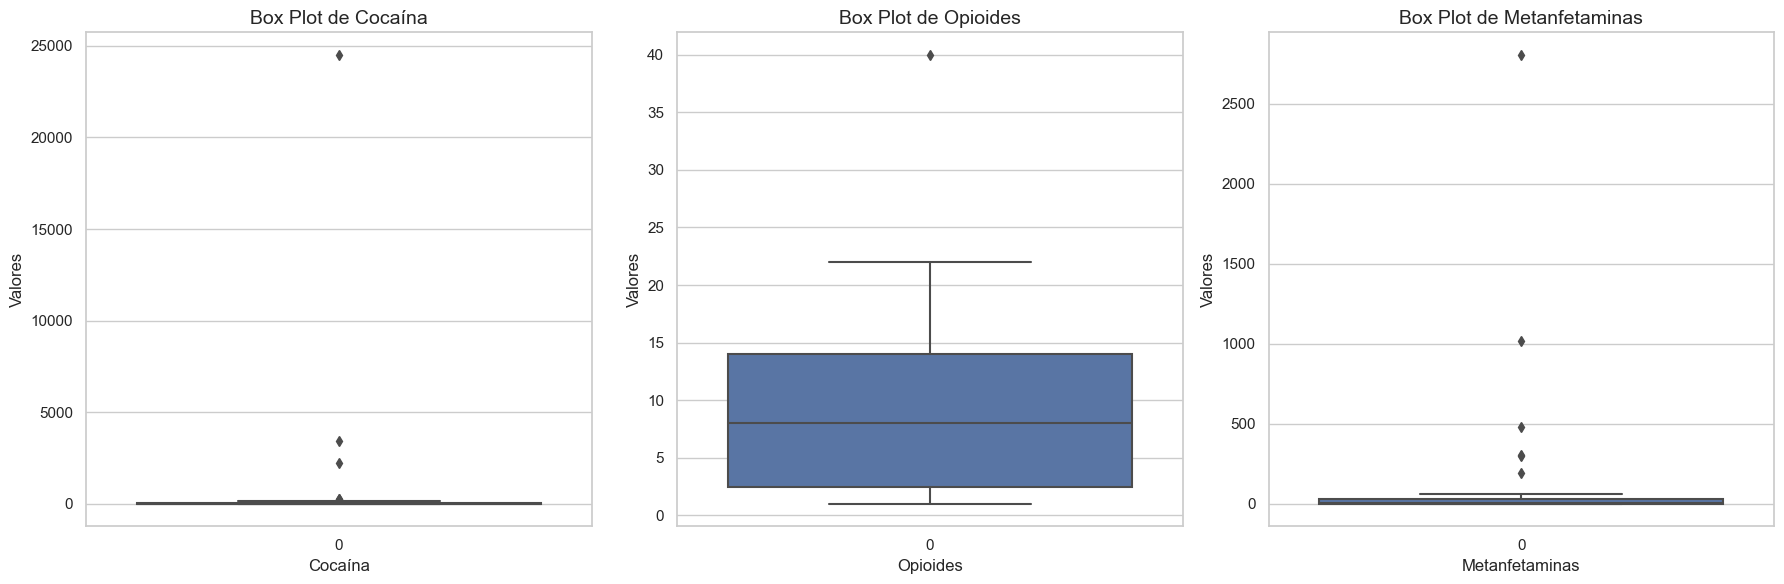

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(data=df_produccion['Cocaína'], ax=axes[0])
axes[0].set_title('Box Plot de Cocaína', fontsize=14)
axes[0].set_xlabel('Cocaína', fontsize=12)
axes[0].set_ylabel('Valores', fontsize=12)

sns.boxplot(data=df_produccion['Opioides'], ax=axes[1])
axes[1].set_title('Box Plot de Opioides', fontsize=14)
axes[1].set_xlabel('Opioides', fontsize=12)
axes[1].set_ylabel('Valores', fontsize=12)

sns.boxplot(data=df_produccion['Metanfetaminas'], ax=axes[2])
axes[2].set_title('Box Plot de Metanfetaminas', fontsize=14)
axes[2].set_xlabel('Metanfetaminas', fontsize=12)
axes[2].set_ylabel('Valores', fontsize=12)

plt.tight_layout()
plt.show()

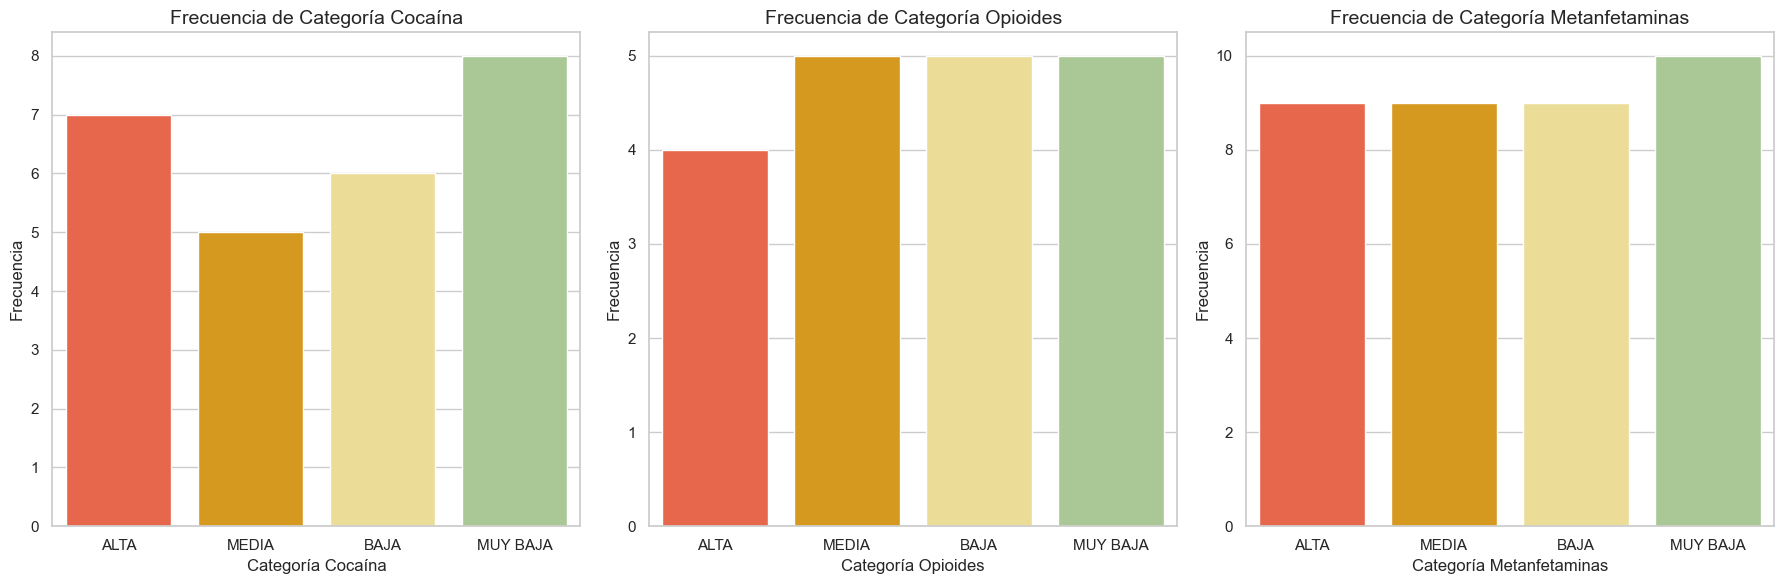

In [15]:
palette = {'MUY BAJA': '#A8D08D', 'BAJA':  '#F9E68A', 'MEDIA': '#F4A300', 'ALTA': '#FF5733'}


df_categories = df_produccion[['Categoría_Cocaína', 'Categoría_Opioides', 'Categoría_Metanfetaminas']]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.countplot(x='Categoría_Cocaína', data=df_categories, ax=axes[0], palette=palette, order=['ALTA', 'MEDIA', 'BAJA', 'MUY BAJA'])
axes[0].set_title('Frecuencia de Categoría Cocaína', fontsize=14)
axes[0].set_xlabel('Categoría Cocaína', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)

sns.countplot(x='Categoría_Opioides', data=df_categories, ax=axes[1], palette=palette, order=['ALTA', 'MEDIA', 'BAJA', 'MUY BAJA'])
axes[1].set_title('Frecuencia de Categoría Opioides', fontsize=14)
axes[1].set_xlabel('Categoría Opioides', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)

sns.countplot(x='Categoría_Metanfetaminas', data=df_categories, ax=axes[2], palette=palette, order=['ALTA', 'MEDIA', 'BAJA', 'MUY BAJA'])
axes[2].set_title('Frecuencia de Categoría Metanfetaminas', fontsize=14)
axes[2].set_xlabel('Categoría Metanfetaminas', fontsize=12)
axes[2].set_ylabel('Frecuencia', fontsize=12)

plt.tight_layout()
plt.show()

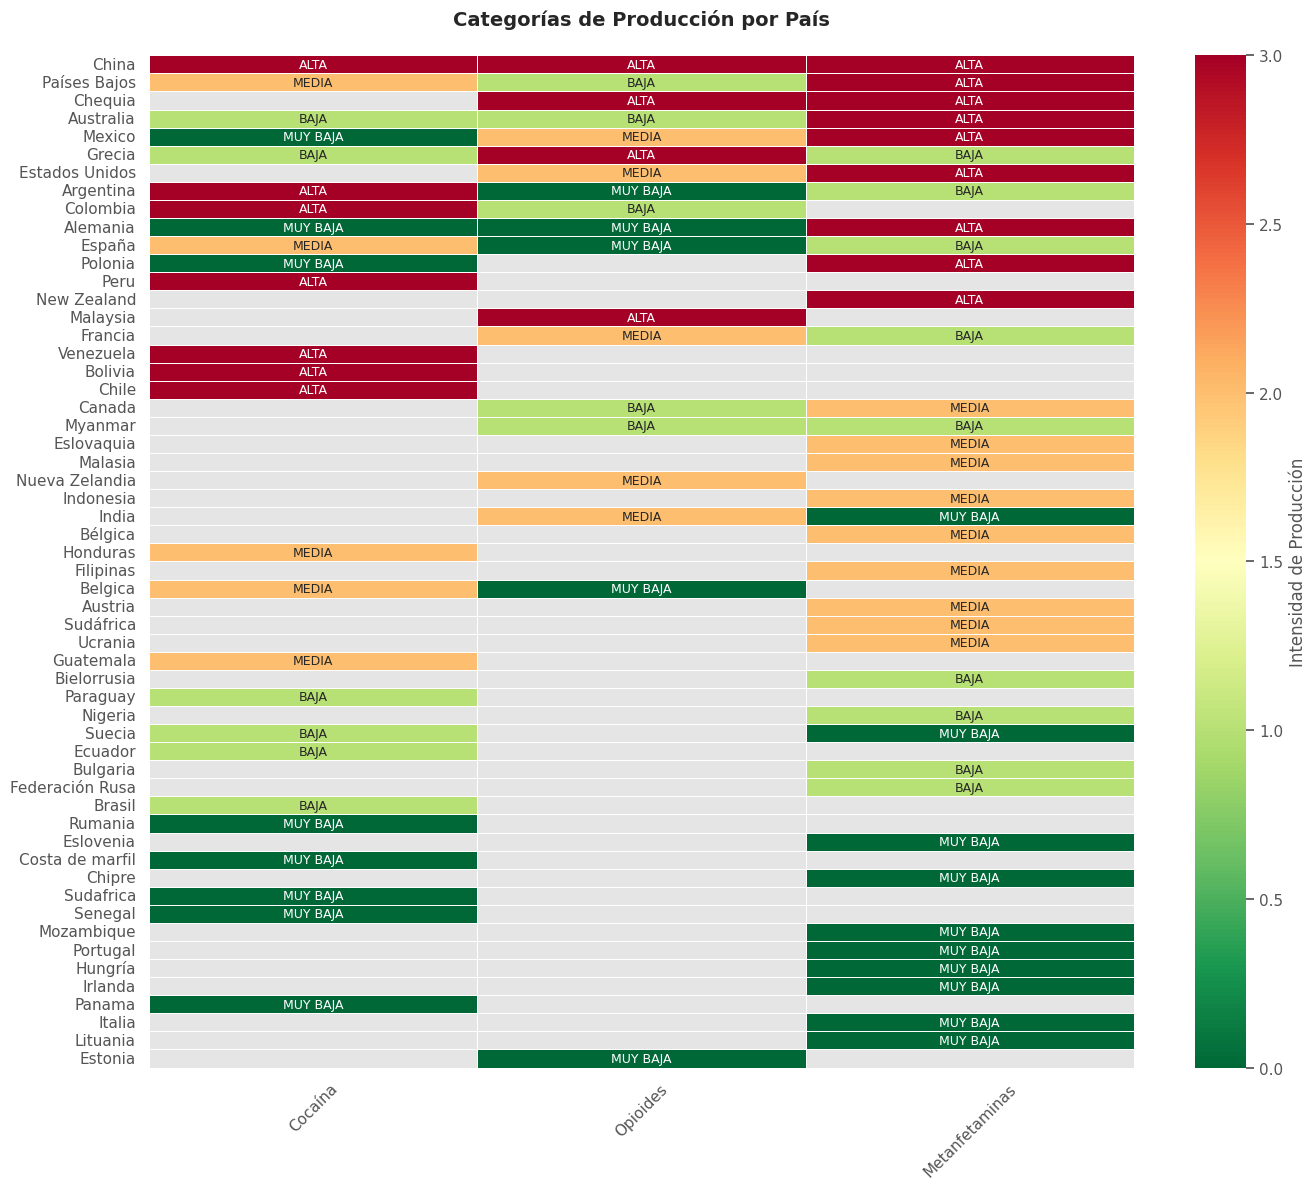

In [16]:
plt.style.use('ggplot')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'

def plot_heatmap():
    categorias = df_produccion[['País', 'Categoría_Cocaína', 'Categoría_Opioides', 'Categoría_Metanfetaminas']].dropna(how='all')
    
    order = categorias.fillna('Z').apply(lambda x: x.map({'ALTA':3, 'MEDIA':2, 'BAJA':1, 'MUY BAJA':0})).sum(axis=1).sort_values(ascending=False).index
    categorias = categorias.iloc[order]
    
    heatmap_data = categorias[['Categoría_Cocaína', 'Categoría_Opioides', 'Categoría_Metanfetaminas']]\
        .apply(lambda x: x.map({'ALTA':3, 'MEDIA':2, 'BAJA':1, 'MUY BAJA':0, np.nan: np.nan}))
    
    plt.figure(figsize=(14, 12))
    ax = sns.heatmap(heatmap_data, 
                    annot=categorias[['Categoría_Cocaína', 'Categoría_Opioides', 'Categoría_Metanfetaminas']],
                    cmap='RdYlGn_r', 
                    linewidths=0.5,
                    cbar_kws={'label': 'Intensidad de Producción'},
                    annot_kws={'fontsize':9},
                    fmt='')
    
    ax.set_yticklabels(categorias['País'], rotation=0)
    ax.set_xticklabels(['Cocaína', 'Opioides', 'Metanfetaminas'], rotation=45)
    plt.title('Categorías de Producción por País\n', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
plot_heatmap()

In [17]:
df_produccion[['País', 'Cocaína']].sort_values(by='Cocaína', ascending=False).head()

País  Cocaína
15   Colombia  24514.0
6     Bolivia   3446.0
46       Peru   2202.0
1   Argentina    287.0
55  Venezuela    271.0

In [18]:
df_produccion[['País', 'Metanfetaminas']].sort_values(by='Metanfetaminas', ascending=False).head()

País  Metanfetaminas
21  Estados Unidos          2806.0
11         Chequia          1021.0
13           China           479.0
2        Australia           308.0
40     New Zealand           297.0

In [19]:
df_produccion[['País', 'Opioides']].sort_values(by='Opioides', ascending=False).head()

País  Opioides
36  Malaysia      40.0
26    Grecia      22.0
11   Chequia      19.0
13     China      19.0
37    Mexico      14.0

# Consumo

In [20]:
df_consumo = pd.read_csv('../data/consumo.csv')

In [21]:
df_consumo['Total'] = df_consumo[['Cocaína', 'Cannabis', 'Metanfetaminas', 'Opioides']].sum(axis=1, skipna=True)

In [22]:
df_consumo['Categoría_Total'] = pd.cut(df_consumo['Total'], 
                                       bins=[-float('inf'), 3.7, 5.6, 9.45, float('inf')],
                                       labels=['Muy Baja', 'Baja', 'Media', 'Alta'])

In [23]:
df_consumo.head()

País  Cocaína Categoría_Cocaína  Cannabis Categoría_Cannabis  \
0    Albania     2.50              Alta      5.60              Media   
1   Alemania     1.03             Media      6.62              Media   
2    Argelia     0.01          Muy baja      0.52           Muy baja   
3  Argentina     1.20             Media      5.67              Media   
4  Australia     2.73              Alta     10.80               Alta   

   Metanfetaminas Categoría_Metanfetaminas  Opioides Categoría_Opioides  \
0            0.10                 Muy Baja       NaN                NaN   
1            1.15                     Alta      0.36               Baja   
2            0.03                 Muy Baja       NaN                NaN   
3             NaN                      NaN      0.19           Muy baja   
4            1.73                     Alta      3.10               Alta   

   Total Categoría_Total  
0   8.20           Media  
1   9.16           Media  
2   0.56        Muy Baja  
3   7.06           Media  
4  18.36            Alta

In [24]:
df_consumo.describe()

Cocaína   Cannabis  Metanfetaminas   Opioides      Total
count  83.000000  82.000000       63.000000  50.000000  83.000000
mean    0.797108   5.016220        0.683651   0.980600   6.862530
std     0.702470   4.009119        0.854824   1.245528   4.996125
min     0.010000   0.140000        0.020000   0.020000   0.310000
25%     0.250000   2.287500        0.190000   0.255000   3.465000
50%     0.600000   3.915000        0.490000   0.515000   5.240000
75%     1.120000   6.792500        0.875000   1.000000   9.440000
max     2.730000  20.500000        6.100000   5.150000  27.850000

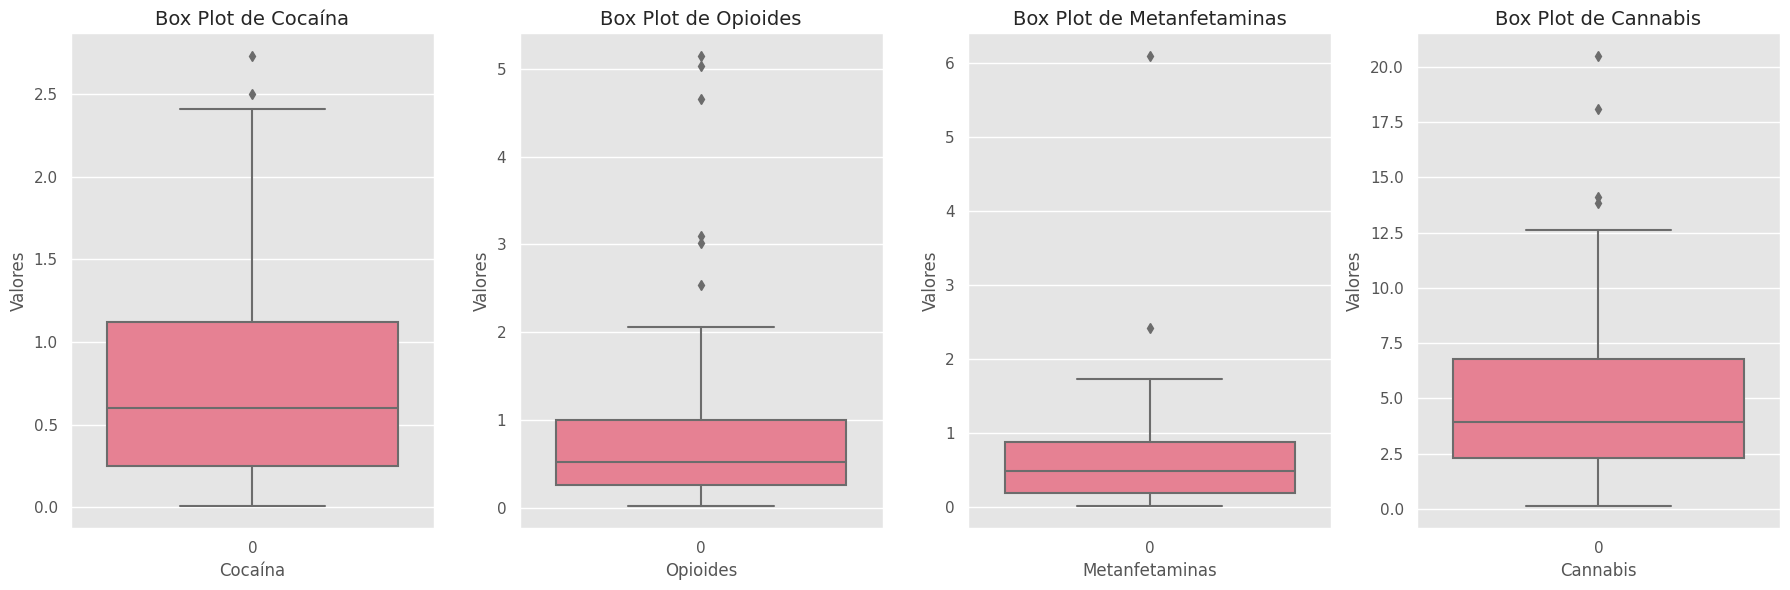

In [25]:
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

sns.boxplot(data=df_consumo['Cocaína'], ax=axes[0])
axes[0].set_title('Box Plot de Cocaína', fontsize=14)
axes[0].set_xlabel('Cocaína', fontsize=12)
axes[0].set_ylabel('Valores', fontsize=12)

sns.boxplot(data=df_consumo['Opioides'], ax=axes[1])
axes[1].set_title('Box Plot de Opioides', fontsize=14)
axes[1].set_xlabel('Opioides', fontsize=12)
axes[1].set_ylabel('Valores', fontsize=12)

sns.boxplot(data=df_consumo['Metanfetaminas'], ax=axes[2])
axes[2].set_title('Box Plot de Metanfetaminas', fontsize=14)
axes[2].set_xlabel('Metanfetaminas', fontsize=12)
axes[2].set_ylabel('Valores', fontsize=12)

sns.boxplot(data=df_consumo['Cannabis'], ax=axes[3])
axes[3].set_title('Box Plot de Cannabis', fontsize=14)
axes[3].set_xlabel('Cannabis', fontsize=12)
axes[3].set_ylabel('Valores', fontsize=12)


plt.tight_layout()
plt.show()

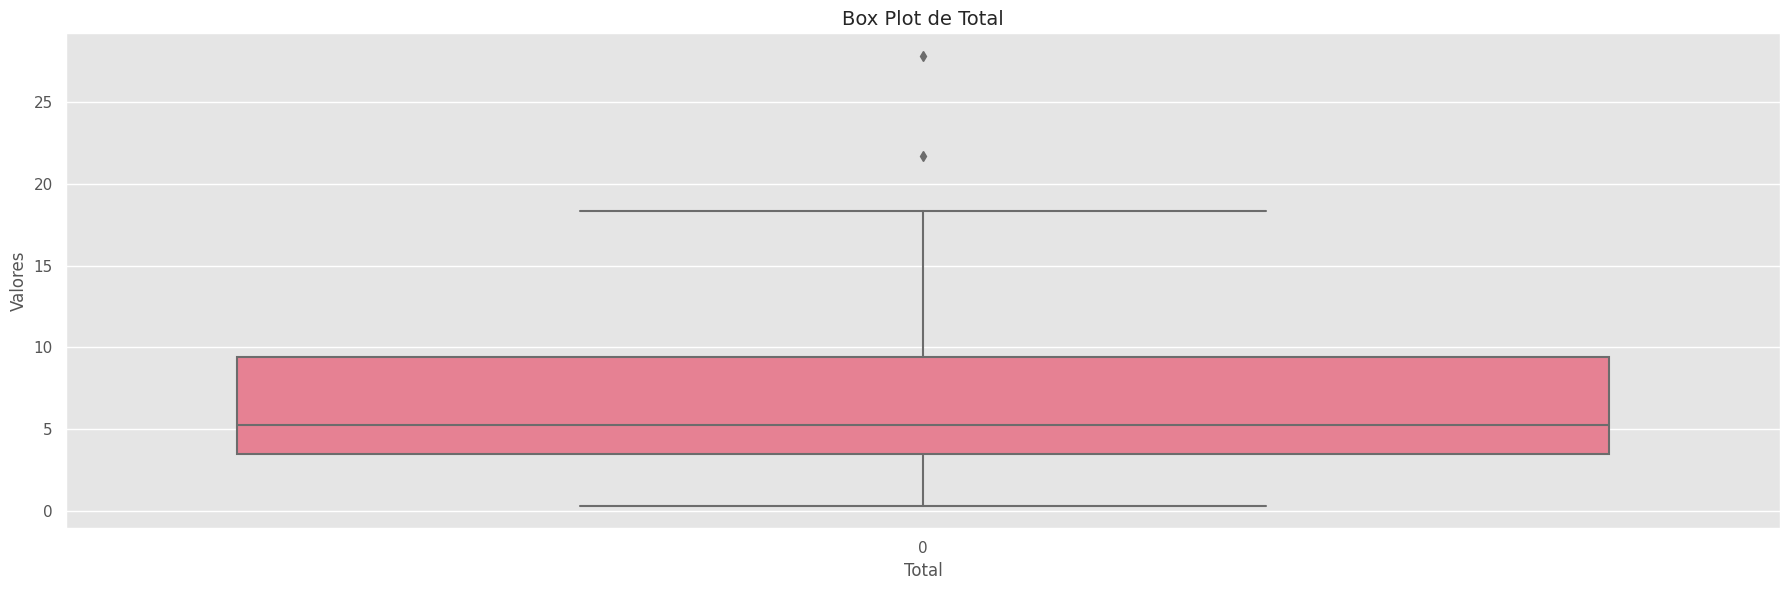

In [26]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(data=df_consumo['Total'], ax=ax)
ax.set_title('Box Plot de Total', fontsize=14)
ax.set_xlabel('Total', fontsize=12)
ax.set_ylabel('Valores', fontsize=12)

plt.tight_layout()
plt.show()

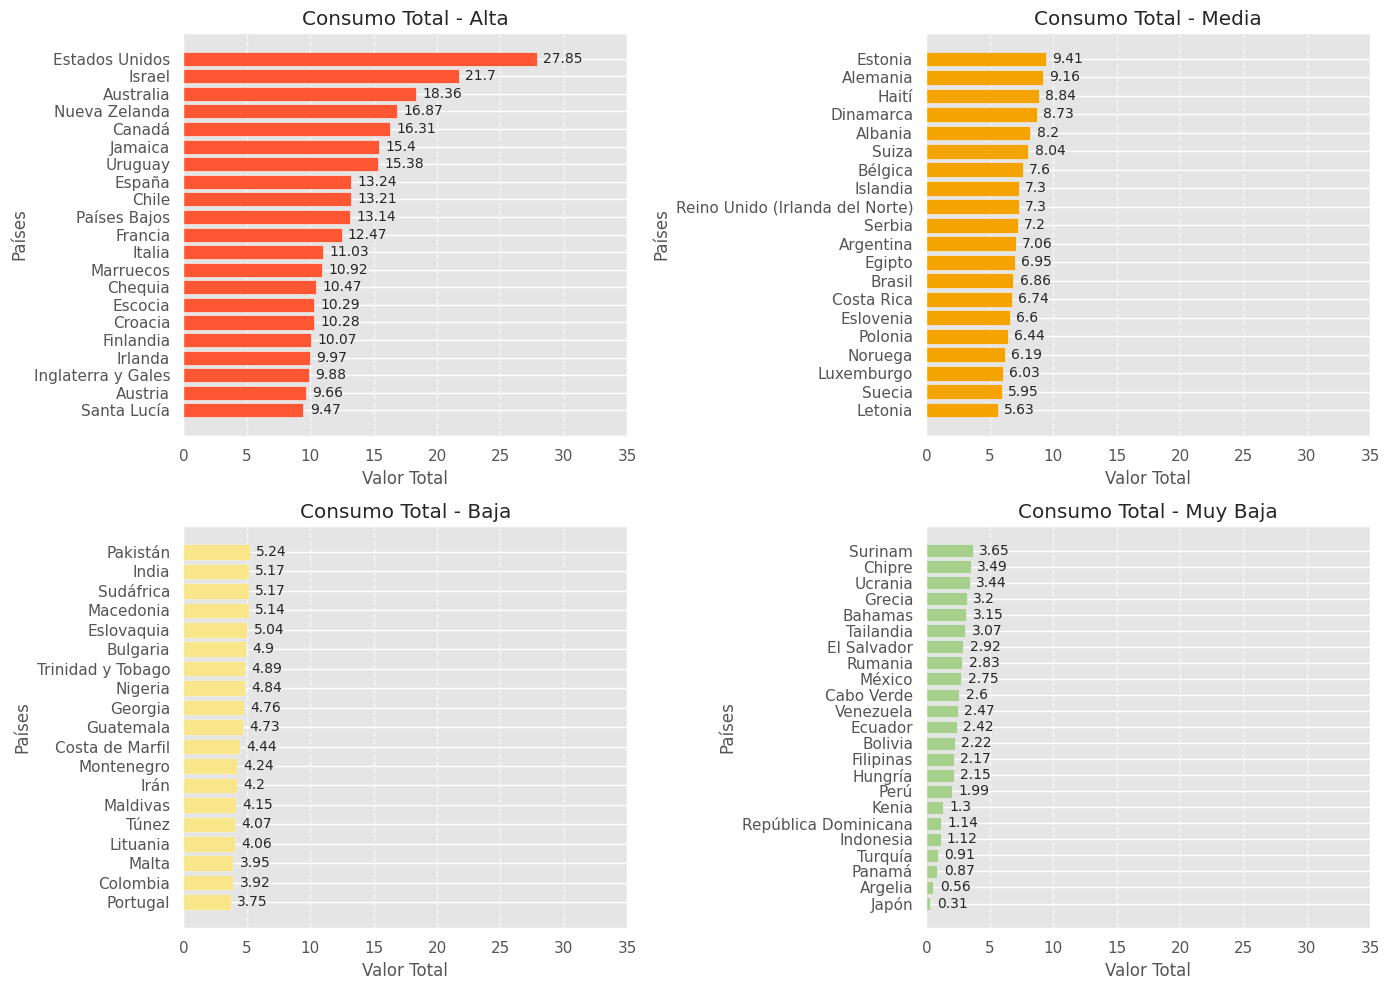

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

palette = {'Muy Baja': '#A8D08D', 'Baja': '#F9E68A', 'Media': '#F4A300', 'Alta': '#FF5733'}

categorias = ['Alta', 'Media', 'Baja', 'Muy Baja']

for i, categoria in enumerate(categorias):
    ax = axes[i//2, i%2]
    df_categoria = df_consumo[df_consumo['Categoría_Total'] == categoria].sort_values(by='Total', ascending=True)
    ax.barh(df_categoria['País'], df_categoria['Total'], color=palette[categoria])
    ax.set_title(f'Consumo Total - {categoria}')
    ax.set_xlabel('Valor Total')
    ax.set_ylabel('Países')
    ax.set_xlim(0, 35)
    
    for index, value in enumerate(df_categoria['Total']):
        ax.text(value + 0.5, index, str(round(value, 2)), va='center')

    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [28]:
df_consumo[['País', 'Cocaína']].sort_values(by='Cocaína', ascending=False).head()

País  Cocaína
4            Australia     2.73
0              Albania     2.50
24             Escocia     2.41
40  Inglaterra y Gales     2.36
28      Estados Unidos     2.31

In [29]:
df_consumo[['País', 'Cannabis']].sort_values(by='Cannabis', ascending=False).head()

País  Cannabis
44          Israel     20.50
28  Estados Unidos     18.09
12          Canadá     14.10
60   Nueva Zelanda     13.83
46         Jamaica     12.61

In [30]:
df_consumo[['País', 'Metanfetaminas']].sort_values(by='Metanfetaminas', ascending=False).head()

País  Metanfetaminas
36           Haití            6.10
28  Estados Unidos            2.42
4        Australia            1.73
76       Tailandia            1.67
63    Países Bajos            1.64

In [31]:
df_consumo[['País', 'Opioides']].sort_values(by='Opioides', ascending=False).head()

País  Opioides
71          Serbia      5.15
28  Estados Unidos      5.03
58         Nigeria      4.66
4        Australia      3.10
42            Irán      3.02

# Trafico

In [32]:
df_trafico = pd.read_csv('../data/trafico.csv')

In [33]:
df_trafico

País        Cocaína  Cannabis  Metanfetaminas        Heroína
0        Sri Lanka  177609.980000   1731.53     4567.113736  145917.640000
1        Australia  159530.390000       NaN    85635.359116  142964.640000
2        Finlandia   94686.555524   5751.15    14874.141876   53374.333333
3        Palestina   75000.000000   4464.29             NaN            NaN
4         Moldavia   71174.380000       NaN             NaN  126448.890000
..             ...            ...       ...             ...            ...
85           Catar            NaN       NaN   136314.067612  136314.070000
86       Bangladés            NaN    172.40             NaN  164051.000000
87      Azerbaiyán            NaN   3938.46     6000.000000   17688.680000
88  Arabia Saudita            NaN   6620.37             NaN            NaN
89         Albania            NaN    881.54             NaN   17793.590000

[90 rows x 5 columns]

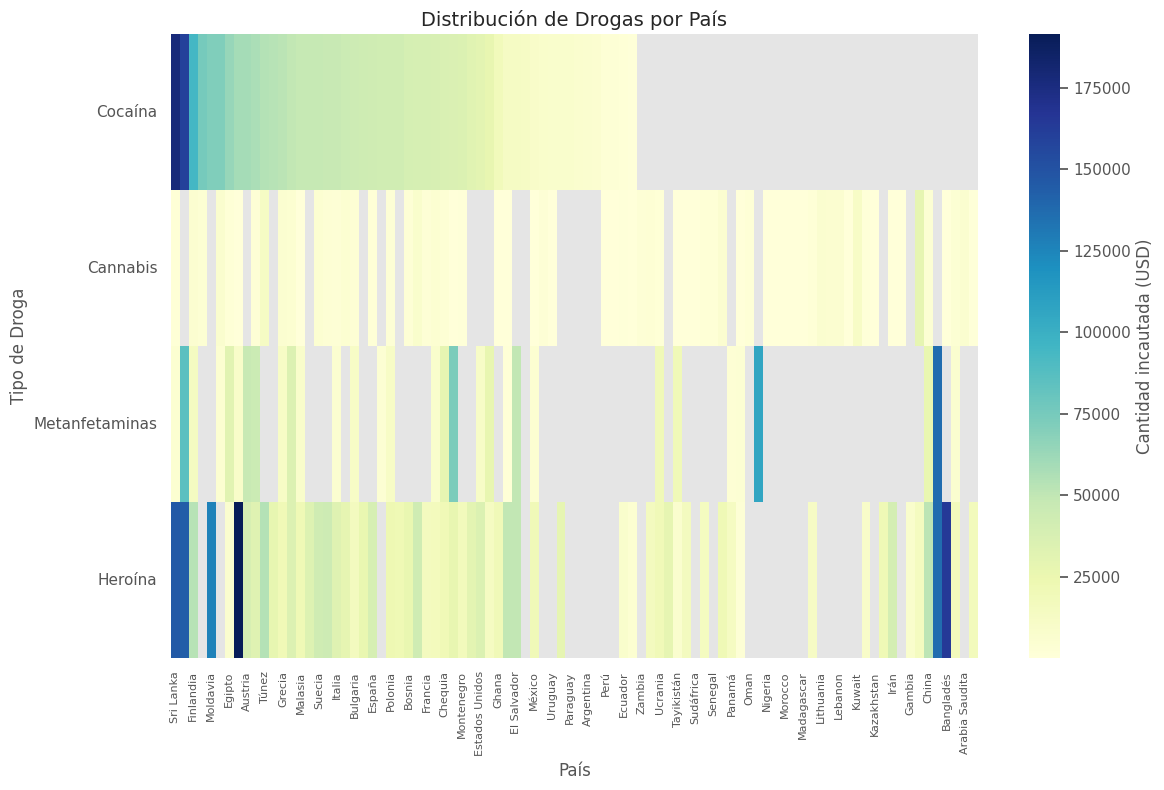

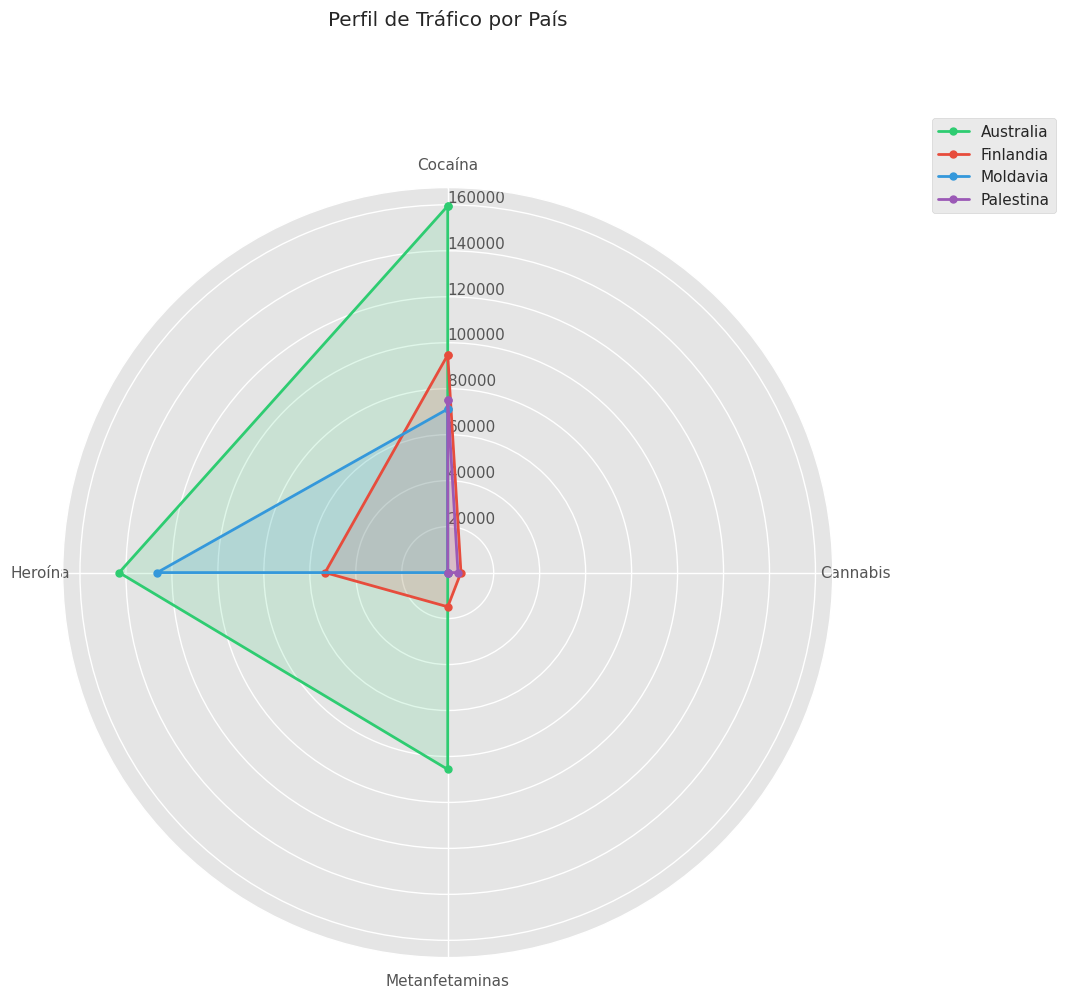

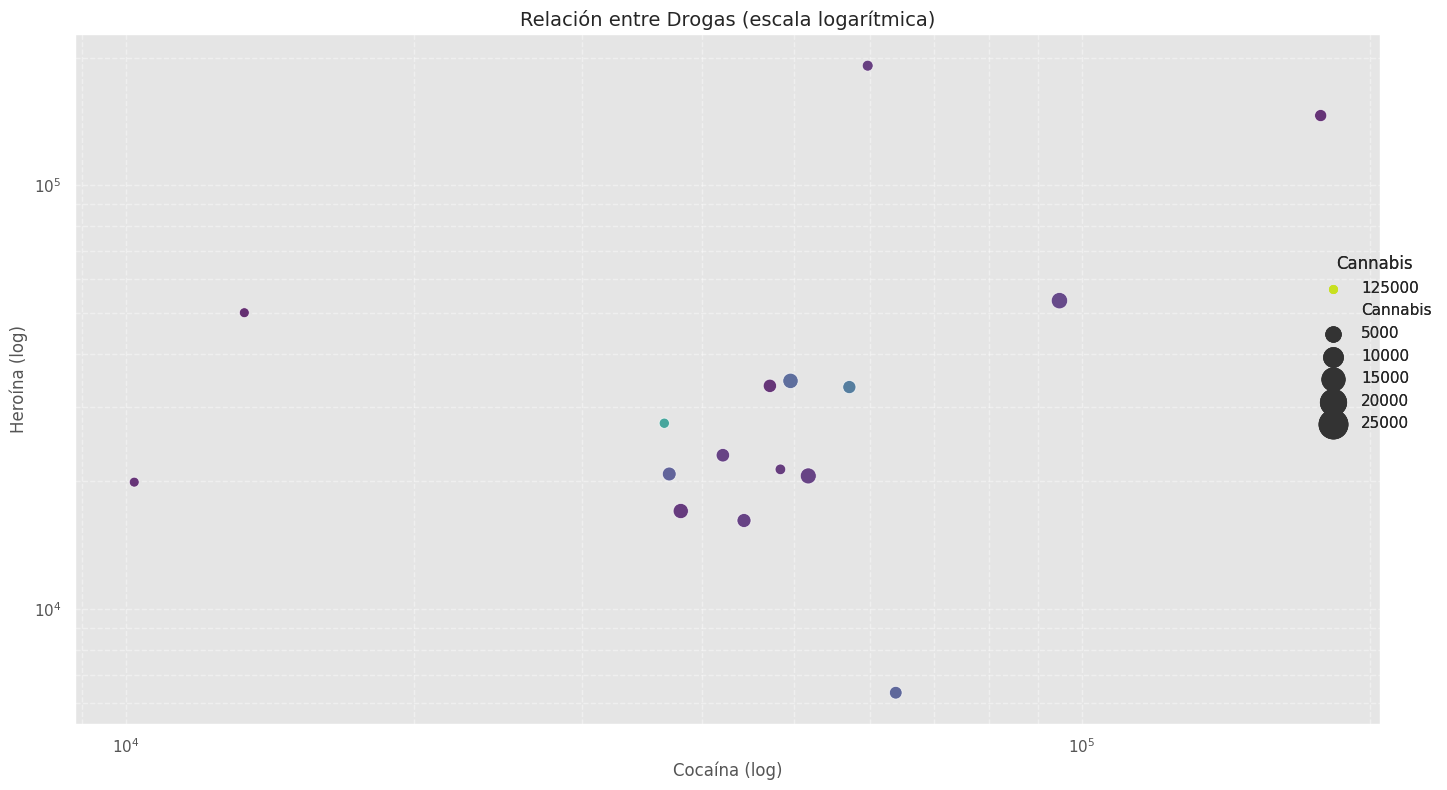

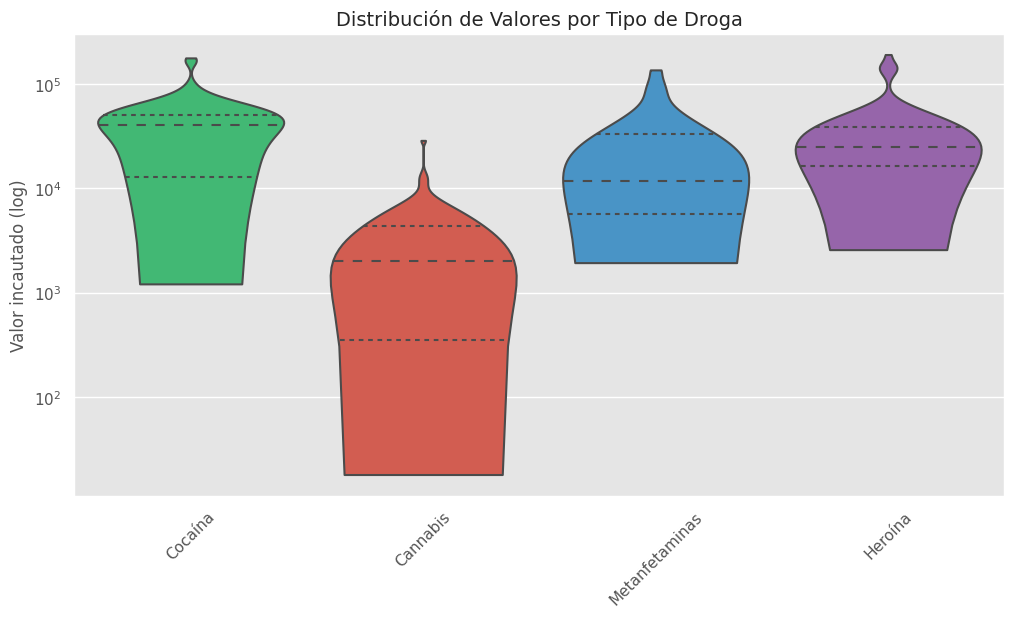

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración estética
plt.style.use('ggplot')
colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6']
sns.set_palette(sns.color_palette(colors))

# 1. Heatmap de distribución por drogas
plt.figure(figsize=(12, 8))
heatmap_data = df_trafico.set_index('País').dropna(how='all')
sns.heatmap(heatmap_data.T, 
           cmap='YlGnBu',
           mask=heatmap_data.T.isnull(),
           cbar_kws={'label': 'Cantidad incautada (USD)'})
plt.title('Distribución de Drogas por País', fontsize=14)
plt.xlabel('País')
plt.ylabel('Tipo de Droga')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Radar chart para comparación multidroga
from math import pi

def plot_radar_chart(countries):
    categories = df_trafico.columns[1:]
    N = len(categories)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    
    for idx, country in enumerate(countries):
        values = df_trafico[df_trafico['País'] == country].iloc[:,1:].fillna(0).values[0]
        values = np.append(values, values[:1])
        
        angles = [n/float(N)*2*pi for n in range(N)]
        angles += angles[:1]
        
        ax.plot(angles, values, linewidth=2, linestyle='solid', 
               label=country, marker='o', markersize=5)
        ax.fill(angles, values, alpha=0.15)
    
    ax.set_theta_offset(pi/2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title('Perfil de Tráfico por País', y=1.2)
    plt.show()

plot_radar_chart(['Australia', 'Finlandia', 'Moldavia', 'Palestina'])

# 3. Bubble Plot multivariable
plt.figure(figsize=(14, 8))
ax = sns.scatterplot(data=df_trafico, 
                    x='Cocaína', 
                    y='Heroína',
                    size='Cannabis',
                    hue='Metanfetaminas',
                    sizes=(50, 500),
                    alpha=0.8,
                    palette='viridis')

# Ajuste de leyendas
h, l = ax.get_legend_handles_labels()
plt.legend(h[1:5], l[1:5], 
          bbox_to_anchor=(1.05, 1), 
          title='Metanfetaminas',
          borderaxespad=0)

size_legend = plt.legend(h[5:], l[5:], 
                        bbox_to_anchor=(1.05, 0.7),
                        title='Cannabis',
                        frameon=False)

ax.add_artist(size_legend)

plt.xscale('log')
plt.yscale('log')
plt.title('Relación entre Drogas (escala logarítmica)', fontsize=14)
plt.xlabel('Cocaína (log)')
plt.ylabel('Heroína (log)')
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 4. Gráfico de violín para distribución por droga
melted_df = df_trafico.melt(id_vars='País', var_name='Droga', value_name='Valor')
plt.figure(figsize=(12, 6))
sns.violinplot(data=melted_df.dropna(), 
              x='Droga', 
              y='Valor',
              inner='quartile',
              cut=0,
              scale='width')
plt.yscale('log')
plt.title('Distribución de Valores por Tipo de Droga', fontsize=14)
plt.xlabel('')
plt.ylabel('Valor incautado (log)')
plt.xticks(rotation=45)
plt.show()

# Mercado

In [35]:
df_mercado = pd.read_csv('../data/mercado.csv')

In [36]:
df_mercado.sort_values(by='Consumo_Tn', ascending=False).head(20)

País  Población  Consumo_Tn   Mercado_USD
0   Estados Unidos    7409071  614.952893  1.875606e+10
1           Brasil    4488953  372.583099  9.314577e+08
2            India    1300000  107.900000  6.438035e+09
3           España    1056208   87.665264  3.748080e+09
4         Alemania     831375   69.004125  3.039619e+09
5          Francia     795088   65.992304  2.544187e+09
6           México     784635   65.124705  6.643807e+08
7        Australia     668847   55.514301  8.856218e+09
8           Italia     656593   54.497219  2.396256e+09
9        Argentina     506004   41.998332  2.099917e+08
10          Egipto     315000   26.145000  1.669007e+09
11        Colombia     314565   26.108895  3.172387e+07
12         Ecuador     276923   22.984609  4.799186e+07
13       Venezuela     217914   18.086862  3.776537e+07
14         Polonia     215600   17.894800  7.533673e+08
15            Perú     210603   17.480049  4.894414e+07
16       Guatemala     190788   15.835404  2.105821e+08
17         Austria     121585   10.091555  5.626371e+08
18         Bélgica     112398    9.329034  3.548685e+08
19          Suecia     100398    8.333034  3.899864e+08

Resumen estadístico:
        Población Consumo_Tn     Mercado_USD
count       36.00      36.00           36.00
mean    587899.11      48.80   1477344388.63
std    1404069.32     116.54   3522142045.08
min       6480.00       0.54      4145815.94
25%      40275.00       3.34     48706068.80
50%     116991.50       9.71    187346360.13
75%     543651.25      45.12    797889928.44
max    7409071.00     614.95  18756063236.50


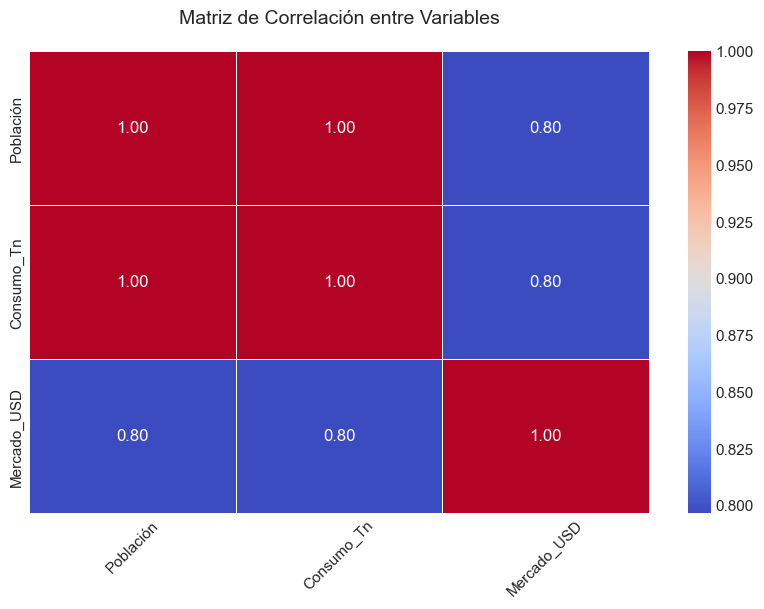

AttributeError: 'numpy.ndarray' object has no attribute 'set_xscale'

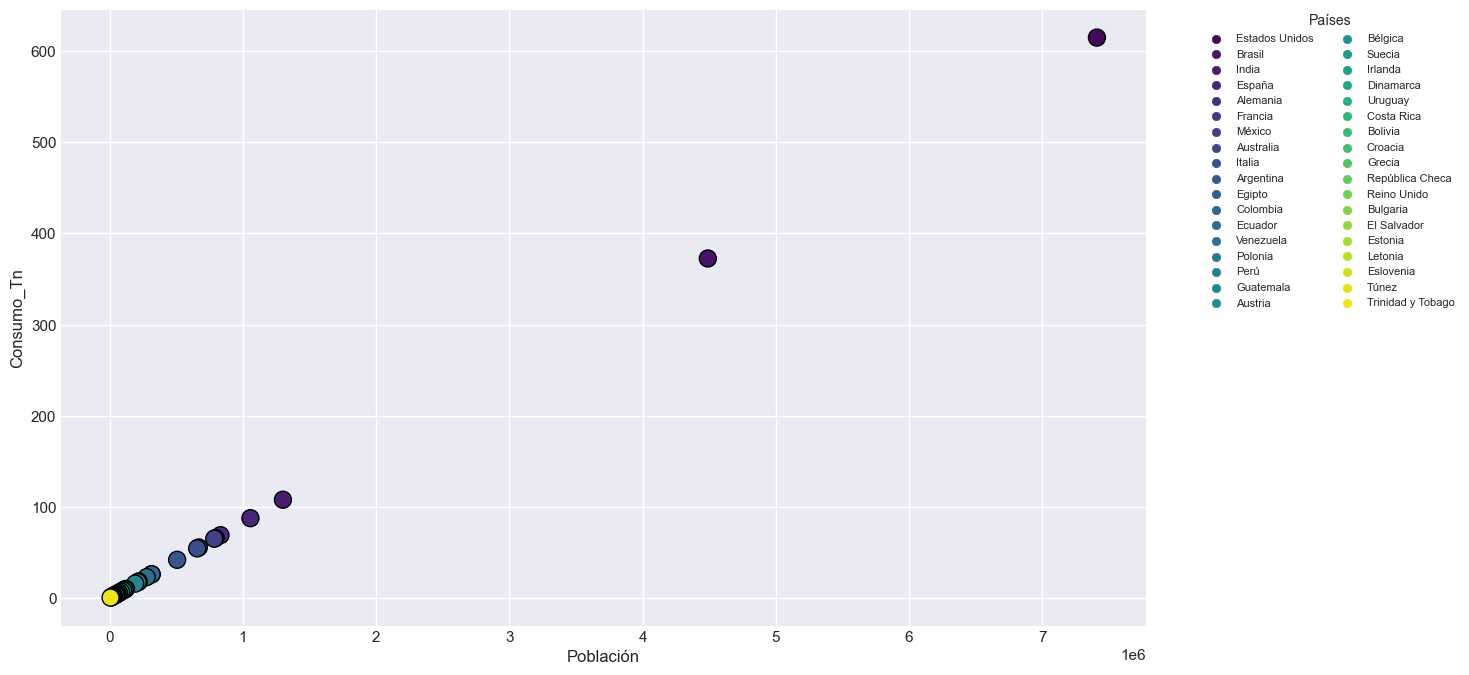

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración de estilo
plt.style.use('seaborn-darkgrid')
palette = sns.color_palette("viridis", n_colors=len(df_mercado))

# 1. Análisis estadístico básico
print("Resumen estadístico:")
print(df_mercado.describe().apply(lambda x: x.apply("{0:.2f}".format)))

# 2. Matriz de correlación
corr_matrix = df_mercado.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
            annot_kws={"size":12}, linewidths=0.5)
plt.title("Matriz de Correlación entre Variables", fontsize=14, pad=20)
plt.xticks(rotation=45)
plt.show()

# 3. Scatter Plots con transformación logarítmica
plt.figure(figsize=(14, 8))
ax = sns.scatterplot(data=df_mercado, x='Población', y='Consumo_Tn', 
                    hue='País', palette=palette, s=150, edgecolor='black')


handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, 
          bbox_to_anchor=(1.05, 1),  # Posición fuera del gráfico a la derecha
          loc='upper left', 
          borderaxespad=0.,
          ncol=2,  # Dos columnas
          fontsize=8,  # Tamaño reducido
          title='Países',
          title_fontsize=10,
          frameon=False)

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title("Relación Población vs Consumo (escala logarítmica)", fontsize=12)
axes[0].set_xlabel("Población (log)", fontsize=10)
axes[0].set_ylabel("Consumo en Toneladas (log)", fontsize=10)

# Consumo vs Valor de Mercado
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_mercado, x='Consumo_Tn', y='Mercado_USD', 
                hue='País', palette=palette, s=150, edgecolor='black')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, 
          bbox_to_anchor=(1.05, 1),  # Posición fuera del gráfico a la derecha
          loc='upper left', 
          borderaxespad=0.,
          ncol=2,  # Dos columnas
          fontsize=8,  # Tamaño reducido
          title='Países',
          title_fontsize=10,
          frameon=False)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title("Relación Consumo vs Valor de Mercado (escala logarítmica)", fontsize=12)
axes[1].set_xlabel("Consumo en Toneladas (log)", fontsize=10)
axes[1].set_ylabel("Valor de Mercado USD (log)", fontsize=10)

# Población vs Valor de Mercado
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_mercado, x='Población', y='Mercado_USD', 
                hue='País', palette=palette, s=150, edgecolor='black')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, 
          bbox_to_anchor=(1.05, 1),  # Posición fuera del gráfico a la derecha
          loc='upper left', 
          borderaxespad=0.,
          ncol=2,  # Dos columnas
          fontsize=8,  # Tamaño reducido
          title='Países',
          title_fontsize=10,
          frameon=False)
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].set_title("Relación Población vs Valor de Mercado (escala logarítmica)", fontsize=12)
axes[2].set_xlabel("Población (log)", fontsize=10)
axes[2].set_ylabel("Valor de Mercado USD (log)", fontsize=10)

plt.tight_layout()
plt.show()

# 4. Análisis de valor por tonelada
df_mercado['USD_por_Tn'] = df_mercado['Mercado_USD'] / df_mercado['Consumo_Tn']
top_countries = df_mercado.sort_values('USD_por_Tn', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_countries, x='USD_por_Tn', y='País', palette='rocket')
plt.title("Top 10 Países por Valor de Mercado por Tonelada", fontsize=14)
plt.xlabel("USD por Tonelada", fontsize=12)
plt.ylabel("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# DataFrame

In [125]:
df_produccion = df_produccion.rename(columns={'Cocaína': 'Cocaína_produccion',
                              'Opioides': 'Opioides_produccion',
                              'Metanfetaminas': 'Metanfetaminas_produccion',
                              'Total':'Total_produccion',
                              'Categoría_Cocaína':'Categoría_Cocaína_produccion',
                              'Categoría_Opioides':'Categoría_Opioides_produccion',
                              'Categoría_Metanfetaminas':'Categoría_Metanfetaminas_produccion'
                        }
                )

In [126]:
df_consumo = df_consumo.rename(columns={'Cocaína': 'Cocaína_consumo',
                              'Opioides': 'Opioides_consumo',
                              'Metanfetaminas': 'Metanfetaminas_consumo',
                              'Cannabis': 'Cannabis_consumo',
                              'Total': 'Total_consumo',
                              'Categoría_Cocaína':'Categoría_Cocaína_consumo',
                              'Categoría_Opioides':'Categoría_Opioides_consumo',
                              'Categoría_Metanfetaminas':'Categoría_Metanfetaminas_consumo',
                              'Categoría_Total': 'Categoría_Total_consumo'
                        }
                )
df_consumo.loc[df_consumo.País == 'Perú', 'País'] = 'Peru'

In [127]:
df_trafico = df_trafico.rename(columns={'Cocaína': 'Cocaína_trafico',
                              'Heroína': 'Heroína_trafico',
                              'Metanfetaminas': 'Metanfetaminas_trafico',
                              'Cannabis': 'Cannabis_trafico'
                        }
                )
df_trafico.loc[df_trafico.País == 'Perú', 'País'] = 'Peru'

In [128]:
df_mercado = df_mercado.rename(columns={'Cocaína': 'Cocaína_trafico',
                              'Heroína': 'Heroína_trafico',
                              'Metanfetaminas': 'Metanfetaminas_trafico',
                              'Cannabis': 'Cannabis_trafico'
                        }
                )
df_mercado.loc[df_mercado.País == 'Perú', 'País'] = 'Peru'

In [129]:
df_cultivo = df_cultivo.rename(columns={'Coca': 'Coca_cultivo',
                              'Opio': 'Opio_cultivo'
                        }
                )

In [130]:
# Realizar el merge con sufijos explícitos
df = (
    df_cultivo
    .merge(df_produccion, on='País', how='outer')
    .merge(df_consumo, on='País', how='outer')
    .merge(df_trafico, on='País', how='outer')
    .merge(df_mercado, on='País', how='outer')
)

In [148]:
# Renombro los paises para mergear con geopandas
renombrar = {
    'Afganistán': 'Afghanistan',
    'Albania': 'Albania',
    'Alemania': 'Germany',
    'Arabia Saudita': 'Saudi Arabia',
    'Argelia': 'Algeria',
    'Argentina': 'Argentina',
    'Australia': 'Australia',
    'Austria': 'Austria',
    'Azerbaiyán': 'Azerbaijan',
    'Bahamas': 'Bahamas',
    'Bangladés': 'Bangladesh',
    'Belgica': 'Belgium',
    'Bielorrusia': 'Belarus',
    'Bolivia': 'Bolivia',
    'Bosnia': 'Bosnia and Herz.',
    'Brasil': 'Brazil',
    'Bulgaria': 'Bulgaria',
    'Bélgica': 'Belgium',
    'Cabo Verde': 'Cape Verde',
    'Canada': 'Canada',
    'Canadá': 'Canada',
    'Catar': 'Qatar',
    'Chequia': 'Czechia',
    'Chile': 'Chile',
    'China': 'China',
    'Chipre': 'Cyprus',
    'Colombia': 'Colombia',
    'Costa Rica': 'Costa Rica',
    'Costa de Marfil': "Côte d'Ivoire",
    'Costa de marfil': "Côte d'Ivoire",
    'Croacia': 'Croatia',
    'Dinamarca': 'Denmark',
    'Ecuador': 'Ecuador',
    'Egipto': 'Egypt',
    'El Salvador': 'El Salvador',
    'Emiratos Árabes Unidos': 'United Arab Emirates',
    'Escocia': 'Scotland',
    'Eslovaquia': 'Slovakia',
    'Eslovenia': 'Slovenia',
    'España': 'Spain',
    'Estados Unidos': 'United States of America',
    'Estonia': 'Estonia',
    'Federación Rusa': 'Russia',
    'Filipinas': 'Philippines',
    'Finlandia': 'Finland',
    'Francia': 'France',
    'Gambia': 'Gambia',
    'Georgia': 'Georgia',
    'Ghana': 'Ghana',
    'Grecia': 'Greece',
    'Guatemala': 'Guatemala',
    'Haití': 'Haiti',
    'Honduras': 'Honduras',
    'Hungría': 'Hungary',
    'India': 'India',
    'Indonesia': 'Indonesia',
    'Inglaterra y Gales': 'United Kingdom',  # Nota que aquí es el Reino Unido
    'Irlanda': 'Ireland',
    'Irán': 'Iran',
    'Islandia': 'Iceland',
    'Israel': 'Israel',
    'Italia': 'Italy',
    'Jamaica': 'Jamaica',
    'Japón': 'Japan',
    'Kazakhstan': 'Kazakhstan',
    'Kenia': 'Kenya',
    'Kirguistán': 'Kyrgyzstan',
    'Kuwait': 'Kuwait',
    'Laos': 'Laos',
    'Latvia': 'Latvia',
    'Lebanon': 'Lebanon',
    'Letonia': 'Latvia',
    'Lithuania': 'Lithuania',
    'Lituania': 'Lithuania',
    'Luxemburgo': 'Luxembourg',
    'Macedonia': 'North Macedonia',
    'Madagascar': 'Madagascar',
    'Malasia': 'Malaysia',
    'Malaysia': 'Malaysia',
    'Maldivas': 'Maldives',
    'Malta': 'Malta',
    'Marruecos': 'Morocco',
    'México': 'Mexico',
    'Moldavia': 'Moldova',
    'Mongolia': 'Mongolia',
    'Montenegro': 'Montenegro',
    'Morocco': 'Morocco',
    'Mozambique': 'Mozambique',
    'Myanmar': 'Myanmar',
    'México': 'Mexico',
    'Nepal': 'Nepal',
    'New Zealand': 'New Zealand',
    'Nigeria': 'Nigeria',
    'Noruega': 'Norway',
    'Nueva Zelanda': 'New Zealand',
    'Nueva Zelandia': 'New Zealand',
    'Oman': 'Oman',
    'Paises Bajos': 'Netherlands',
    'Pakistán': 'Pakistan',
    'Palestina': 'Palestine',
    'Panama': 'Panama',
    'Panamá': 'Panama',
    'Paraguay': 'Paraguay',
    'Países Bajos': 'Netherlands',
    'Peru': 'Peru',
    'Polonia': 'Poland',
    'Portugal': 'Portugal',
    'Reino Unido': 'United Kingdom',
    'Reino Unido (Irlanda del Norte)': 'United Kingdom',
    'República Checa': 'Czechia',
    'República Dominicana': 'Dominican Rep.',
    'Rumania': 'Romania',
    'Santa Lucía': 'Saint Lucia',
    'Scotland': 'United Kingdom',
    'Senegal': 'Senegal',
    'Serbia': 'Serbia',
    'Sri Lanka': 'Sri Lanka',
    'Sudafrica': 'South Africa',
    'Sudáfrica': 'South Africa',
    'Suecia': 'Sweden',
    'Suiza': 'Switzerland',
    'Surinam': 'Suriname',
    'Tailandia': 'Thailand',
    'Tayikistán': 'Tajikistan',
    'Togo': 'Togo',
    'Trinidad y Tobago': 'Trinidad and Tobago',
    'Turquía': 'Turkey',
    'Túnez': 'Tunisia',
    'Ucrania': 'Ukraine',
    'Uruguay': 'Uruguay',
    'Uzbekistán': 'Uzbekistan',
    'Venezuela': 'Venezuela',
    'Zambia': 'Zambia'
}

df['País'] = df['País'].replace(renombrar)

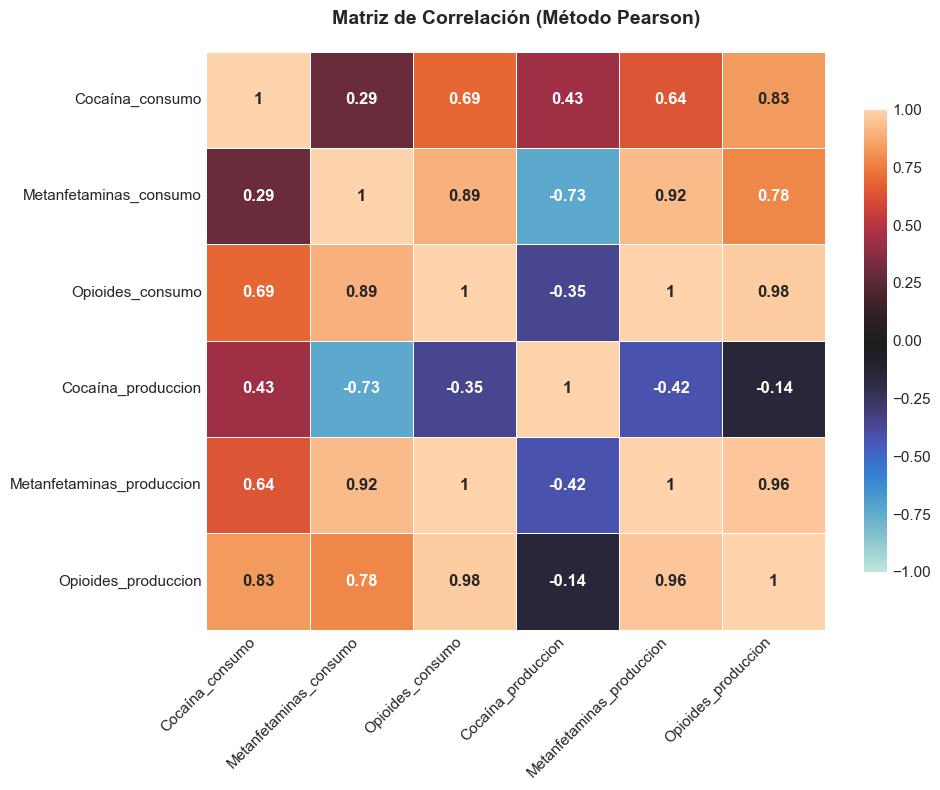

In [122]:
df_corr = df[['Cocaína_consumo','Metanfetaminas_consumo', 'Opioides_consumo', 'Cocaína_produccion',
                      'Metanfetaminas_produccion', 'Opioides_produccion']]\
            .dropna()\
            .apply(pd.to_numeric, errors='coerce')\
            .corr(method='pearson') 

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, 
           annot=True, 
           cmap='icefire', 
           vmin=-1, vmax=1,
           annot_kws={"size":12, "weight":"bold"},
           linewidths=0.5,
           cbar_kws={"shrink":0.8})

plt.title("Matriz de Correlación (Método Pearson)", 
          fontsize=14, pad=20, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [140]:
# Convertir a conjuntos
NAME = set(world.NAME)  # Todos los países en world (el conjunto global)
Pais = set(df.País)  # Países en tu dataset (aproximadamente 70)

# Encuentra los países de df.País que no están en world.NAME
diferencias = Pais - NAME

# Muestra los países en df.País que no están en world.NAME
print("Países en df.País que no están en world.NAME:")
print(diferencias)

Países en df.País que no están en world.NAME:
{'Maldives', 'Saint Lucia', 'Cape Verde', 'Malta'}


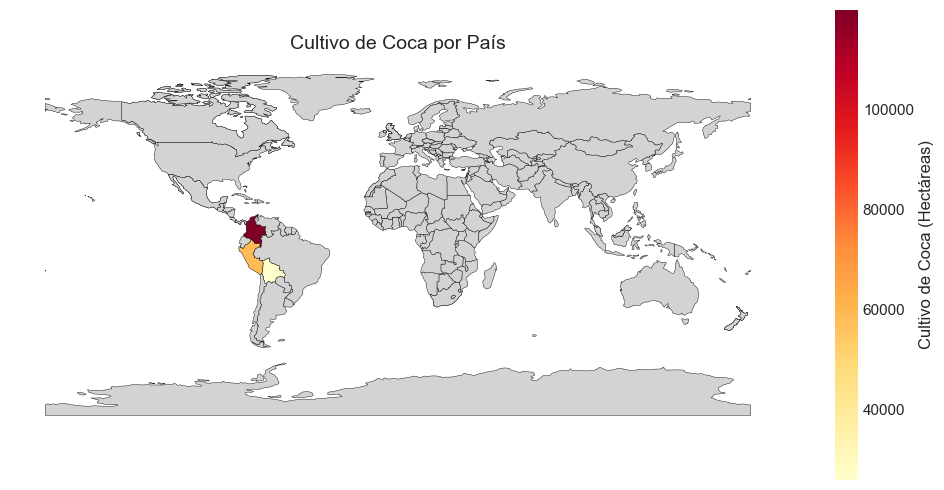

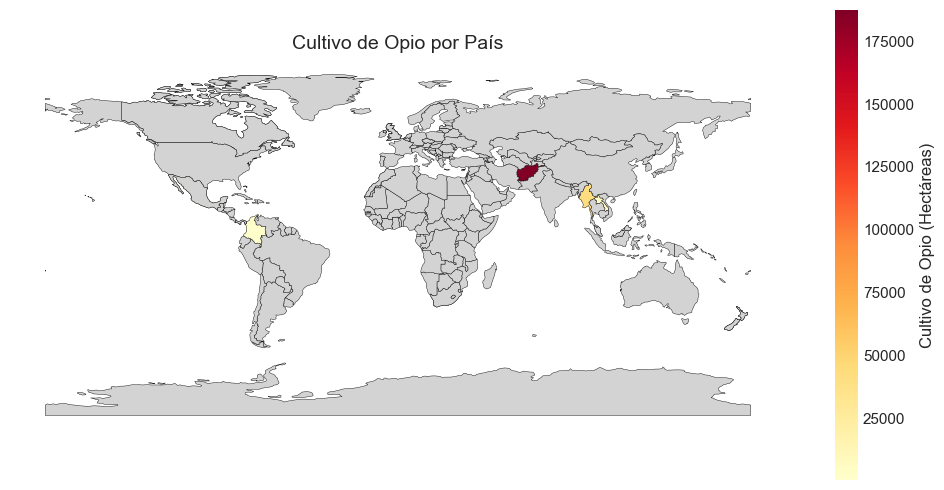

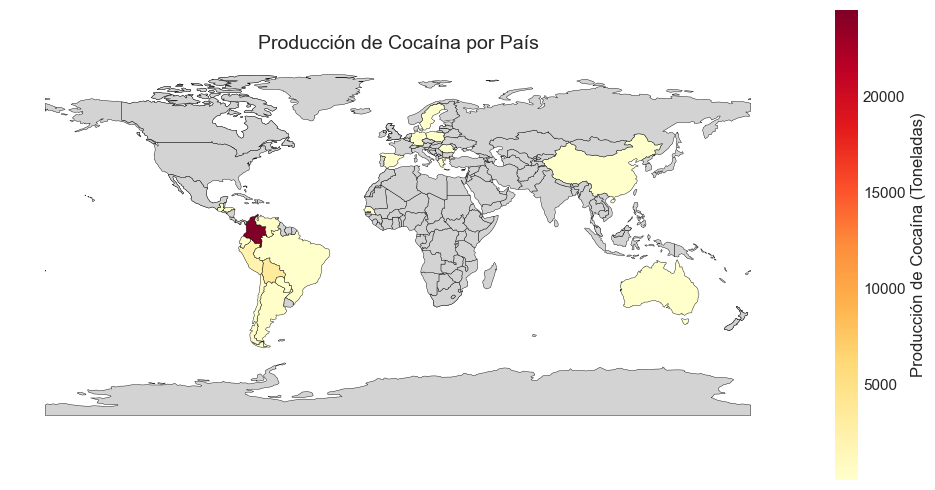

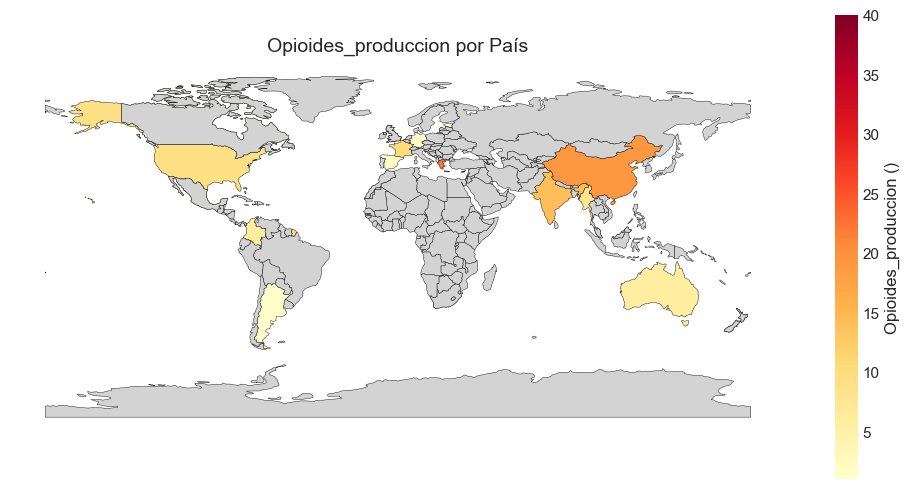

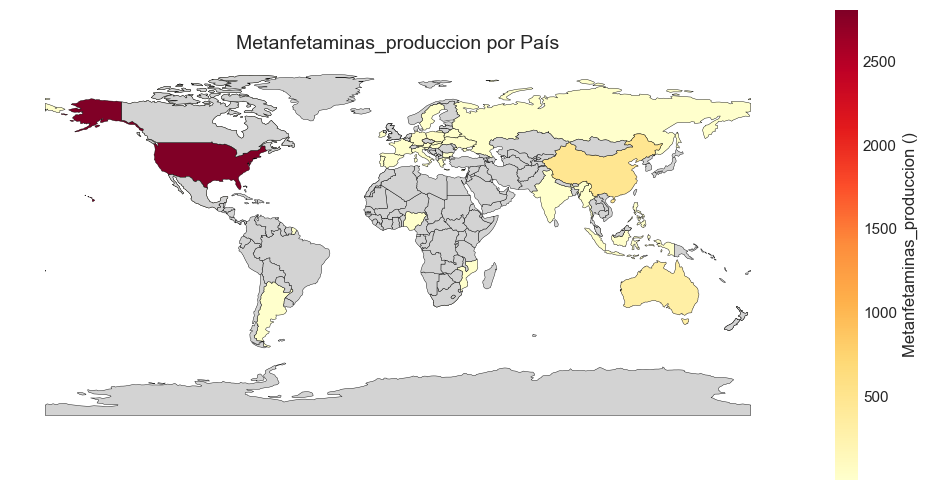

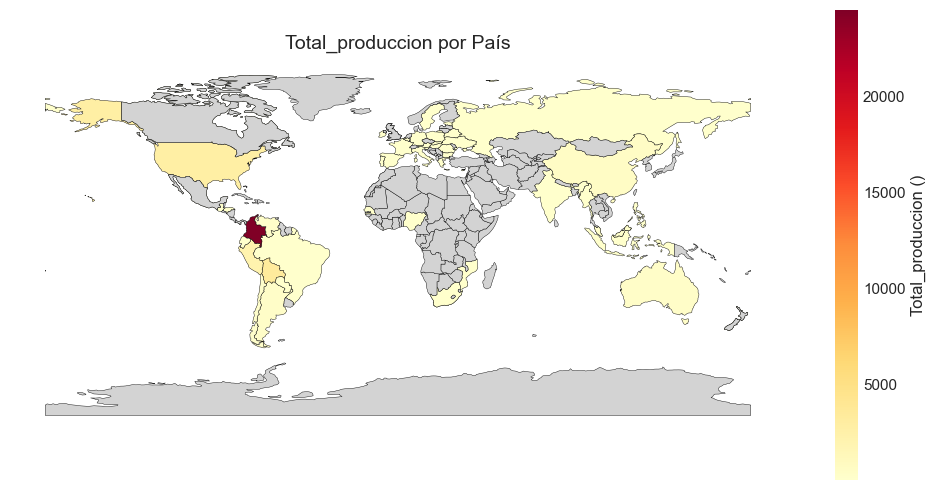

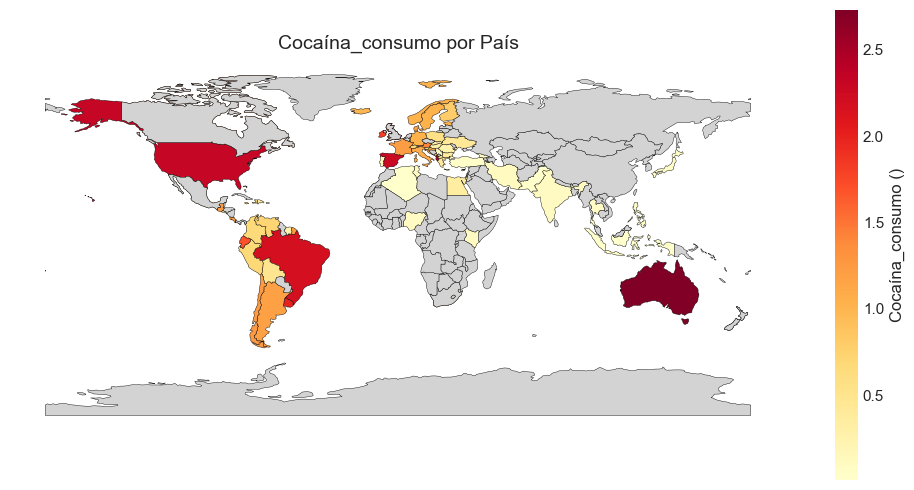

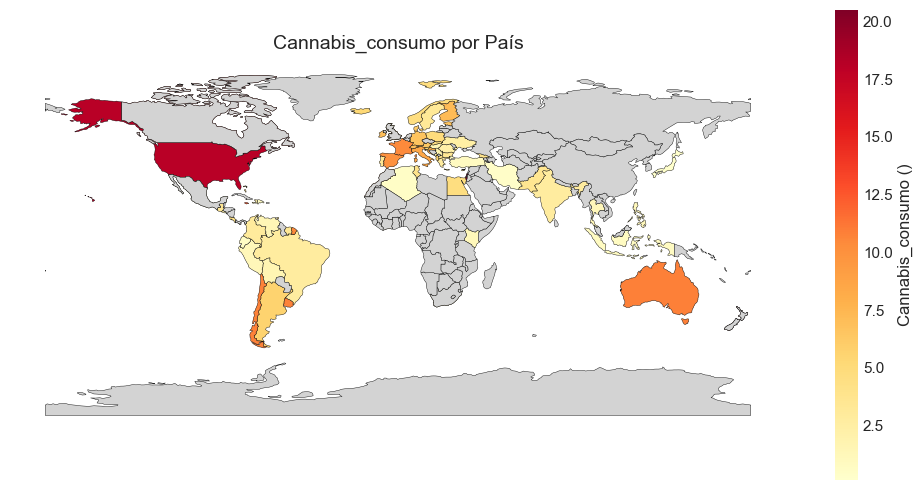

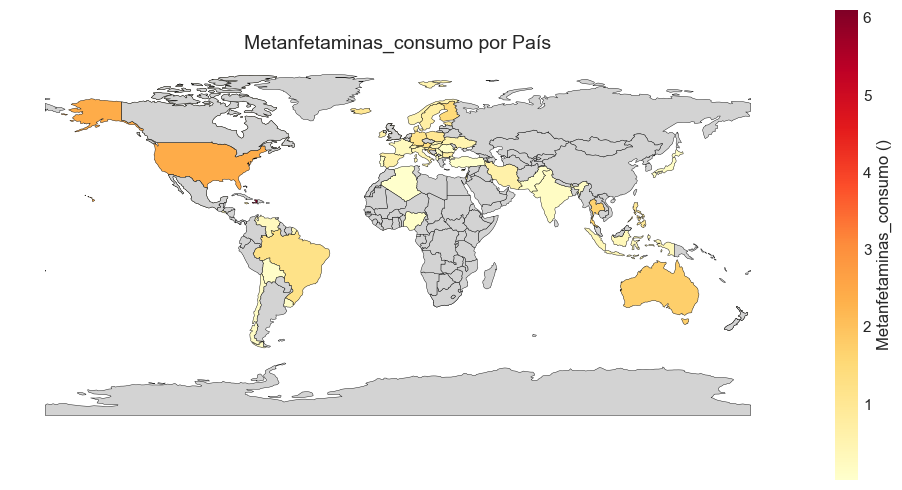

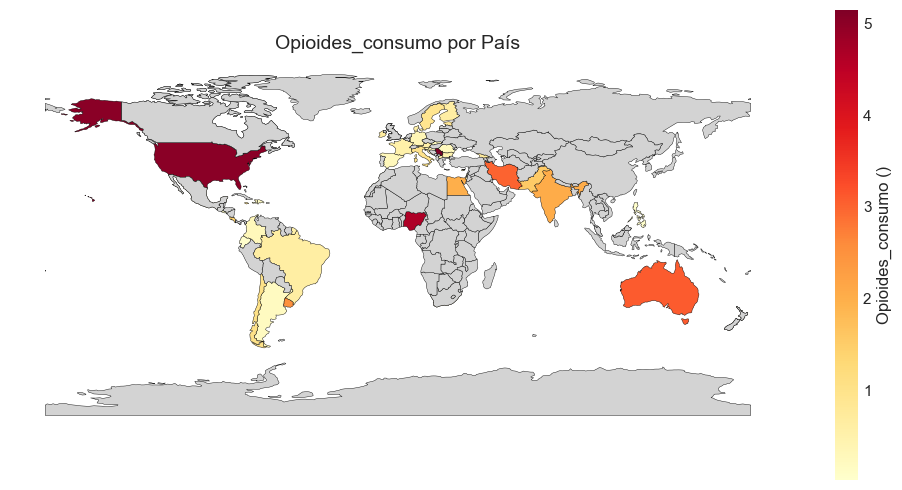

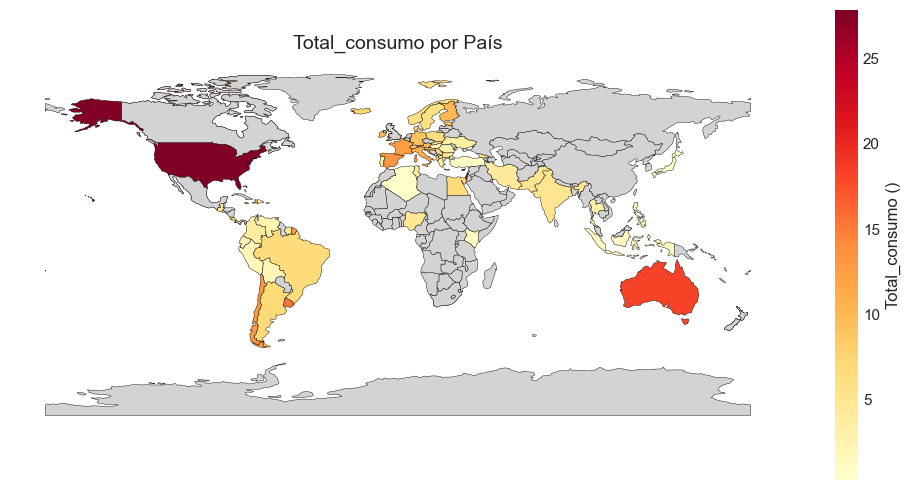

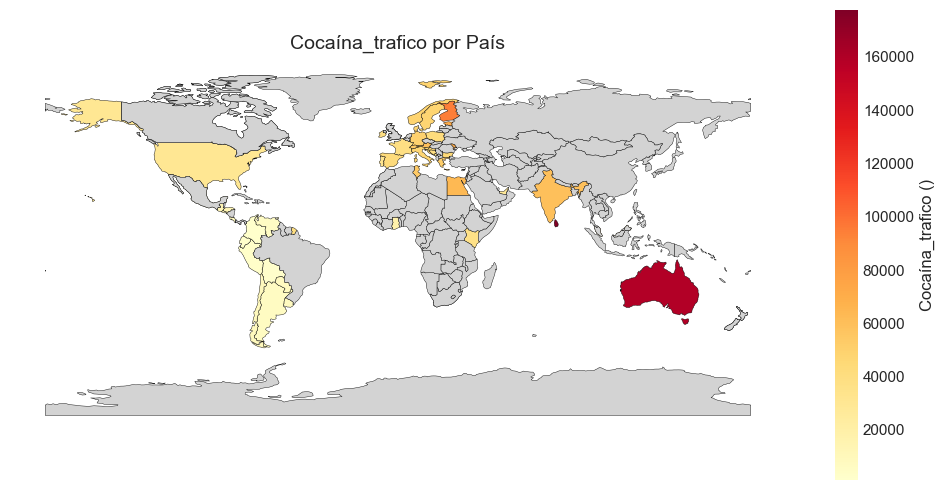

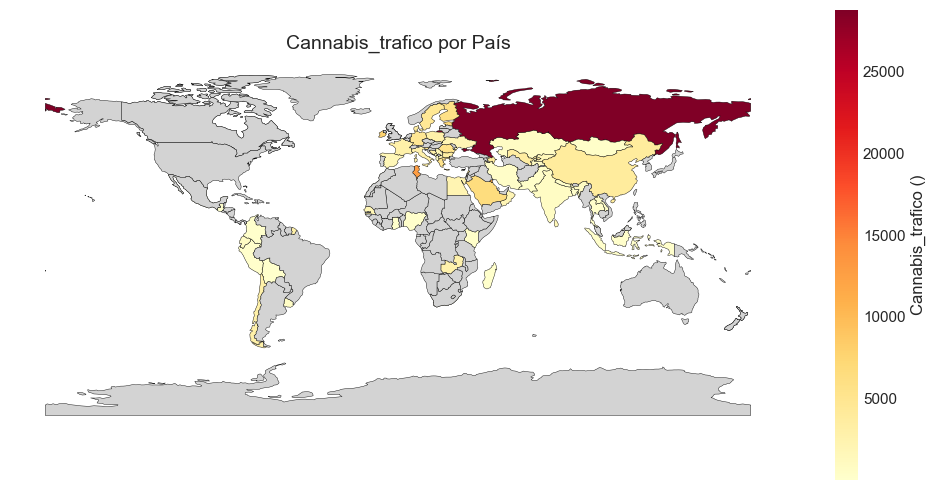

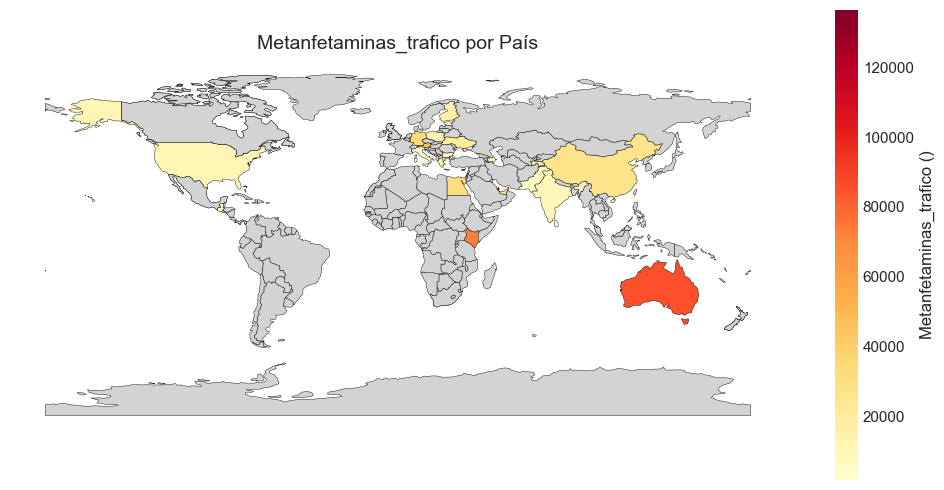

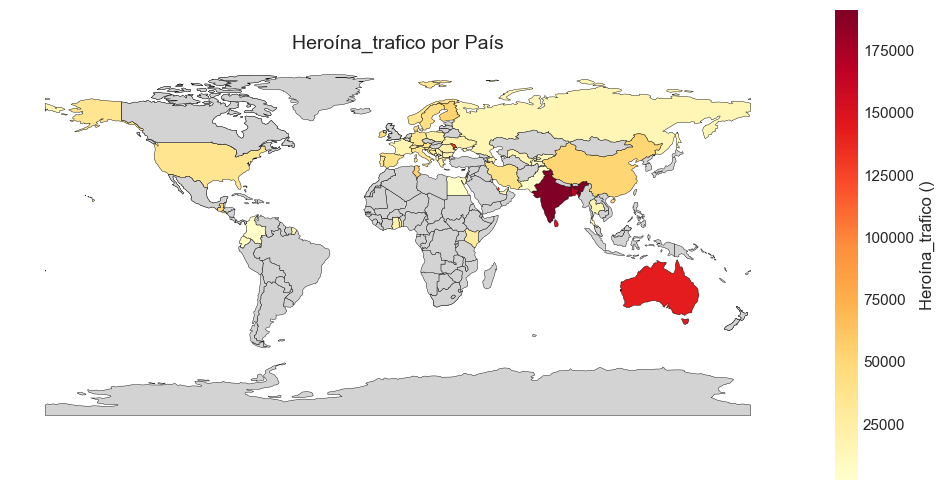

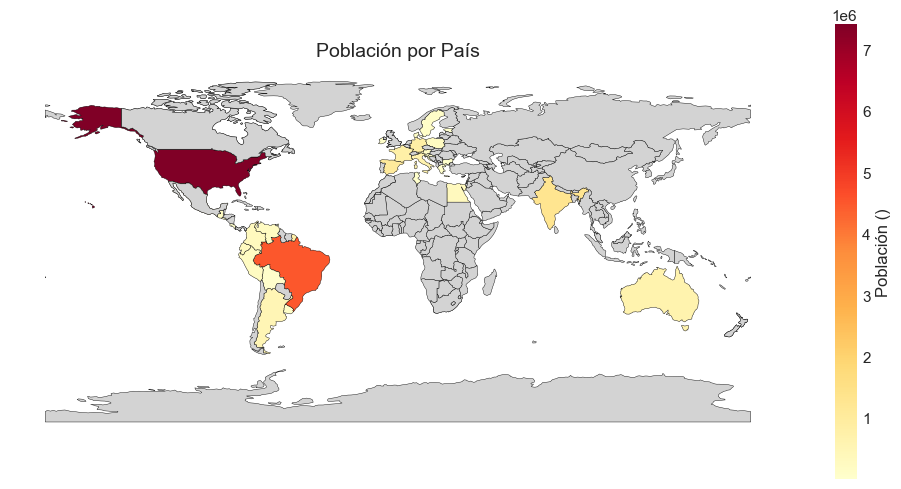

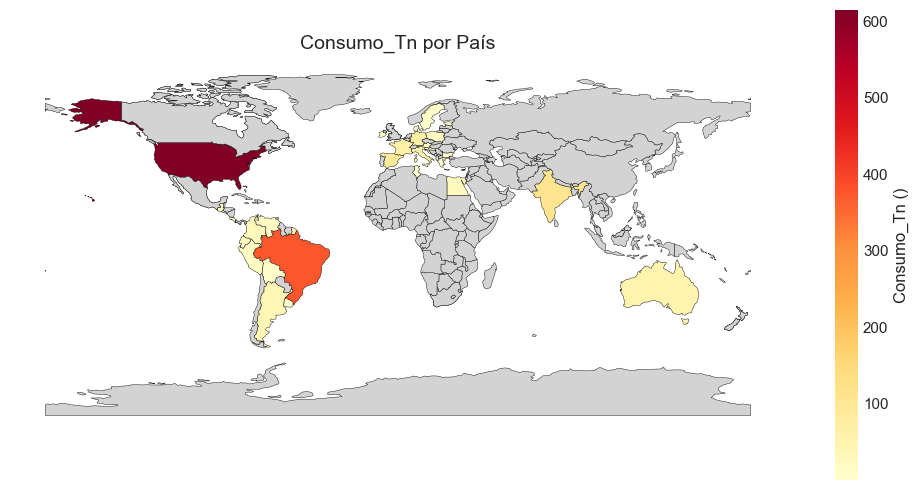

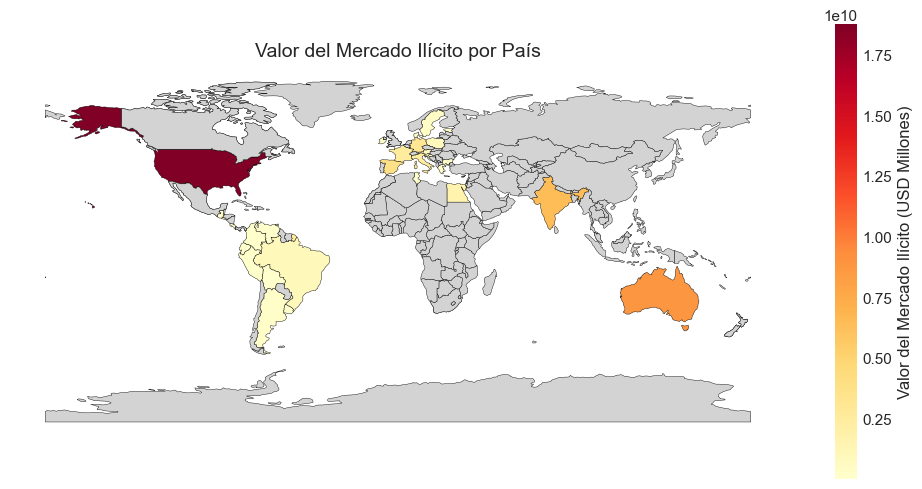

In [149]:
def plot_all_geo_analysis(df):
    
    columnas_numericas = [
        'Coca_cultivo', 'Opio_cultivo', 'Cocaína_produccion',
        'Opioides_produccion', 'Metanfetaminas_produccion', 'Total_produccion',
        'Cocaína_consumo', 'Cannabis_consumo', 'Metanfetaminas_consumo',
        'Opioides_consumo', 'Total_consumo', 'Cocaína_trafico',
        'Cannabis_trafico', 'Metanfetaminas_trafico', 'Heroína_trafico',
        'Población', 'Consumo_Tn', 'Mercado_USD', 
    ]
    
    config_mapas = {
        'Coca_cultivo': {'titulo': 'Cultivo de Coca', 'unidad': 'Hectáreas'},
        'Opio_cultivo': {'titulo': 'Cultivo de Opio', 'unidad': 'Hectáreas'},
        'Cocaína_produccion': {'titulo': 'Producción de Cocaína', 'unidad': 'Toneladas'},
        'Mercado_USD': {'titulo': 'Valor del Mercado Ilícito', 'unidad': 'USD Millones'}
    }

    for columna in columnas_numericas:

        config = config_mapas.get(columna, {'titulo': columna, 'unidad': ''})
        
        merged = world.merge(
            df[['País', columna]],
            left_on='NAME',
            right_on='País',
            how='left'
        )
        
        fig, ax = plt.subplots(figsize=(10, 5))
        merged.plot(
            column=columna,
            ax=ax,
            legend=True,
            legend_kwds={'label': f"{config['titulo']} ({config['unidad']})"},
            missing_kwds={'color': 'lightgrey'},
            edgecolor='black',
            linewidth=0.3,
            cmap='YlOrRd'
        )
        
        plt.title(f"{config['titulo']} por País", fontsize=14)
        ax.set_axis_off()
        plt.tight_layout()
        plt.show()

plot_all_geo_analysis(df)
    

# Grafos

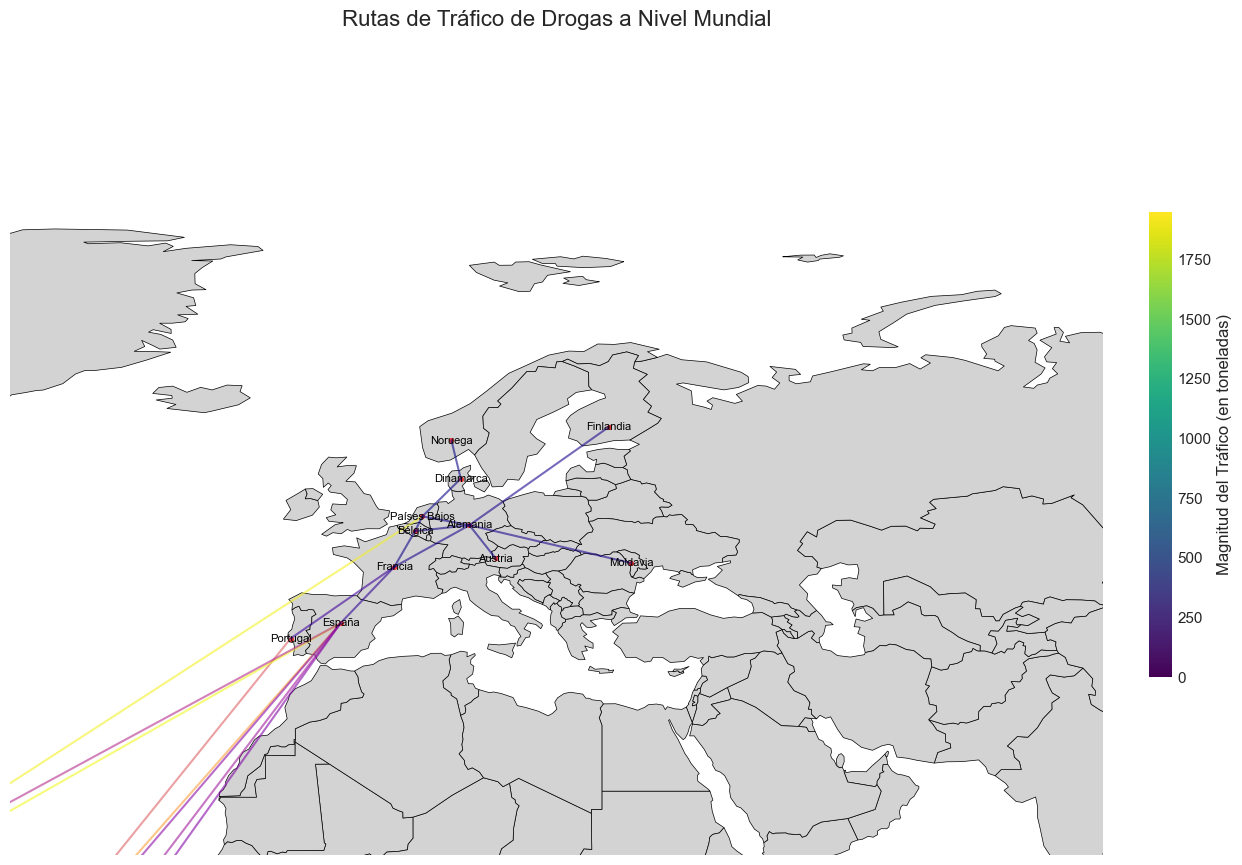

In [190]:
rutas_trafico = [
    ('Colombia', 'Costa Rica', 500.81),
    ('Costa Rica', 'Guatemala', 81.97),
    ('Guatemala', 'México', 100.0),
    ('México', 'Estados Unidos', 198.97),
    ('Colombia', 'Brasil', 300.0),
    ('Brasil', 'Portugal', 1141.82),
    ('Brasil', 'España', 1517.49),
    ('Ecuador', 'España', 1947.63),
    ('Ecuador', 'Países Bajos', 1906.66),
    ('Venezuela', 'España', 800.81),
    ('Argentina', 'España', 677.35),
    ('Paraguay', 'España', 555.59),
    ('Uruguay', 'España', 519.31),
    ('Portugal', 'Francia', 188.46),
    ('España', 'Francia', 121.47),
    ('Francia', 'Alemania', 50.0),
    ('Alemania', 'Austria', 20.04),
    ('Alemania', 'Finlandia', 43.66),
    ('Países Bajos', 'Alemania', 30.0),
    ('Bélgica', 'Alemania', 25.0),
    ('Bélgica', 'Francia', 15.0),
    ('Países Bajos', 'Bélgica', 10.0),
    ('Países Bajos', 'Dinamarca', 5.0),
    ('Dinamarca', 'Noruega', 3.0),
    ('Alemania', 'Moldavia', 43.66)
]

G = nx.DiGraph()

coordenadas_paises = {
    'Colombia': (-74.2973, 4.5709),
    'Costa Rica': (-84.0907, 9.7489),
    'Guatemala': (-90.2308, 15.7835),
    'México': (-102.5528, 23.6345),
    'Estados Unidos': (-99.9018, 37.0902),
    'Brasil': (-51.9253, -14.2350),
    'Portugal': (-9.1900, 38.7369),
    'España': (-3.7038, 40.4168),
    'Ecuador': (-78.1834, -1.8312),
    'Países Bajos': (5.2913, 52.1326),
    'Venezuela': (-66.5897, 6.4238),
    'Argentina': (-63.6167, -38.4161),
    'Paraguay': (-58.4438, -23.4425),
    'Uruguay': (-55.7658, -32.5228),
    'Francia': (2.2137, 46.6034),
    'Alemania': (10.4515, 51.1657),
    'Austria': (13.3330, 47.5162),
    'Finlandia': (25.7482, 61.9241),
    'Bélgica': (4.4699, 50.5039),
    'Dinamarca': (9.5018, 56.2639),
    'Noruega': (8.4689, 60.4720),
    'Moldavia': (28.2336, 47.0105)
}

for pais, coords in coordenadas_paises.items():
    G.add_node(pais, pos=coords)

for ruta in rutas_trafico:
    G.add_edge(ruta[0], ruta[1], weight=ruta[2])

    
plt.ion()
fig, ax = plt.subplots(figsize=(15, 12))

world.plot(ax=ax, color='lightgrey', edgecolor='black')

pos = nx.get_node_attributes(G, 'pos')

nx.draw_networkx_nodes(G, pos, ax=ax, node_size=10, node_color='red', alpha=0.7)
max_weight = max([data['weight'] for u, v, data in G.edges(data=True)])


for u, v, data in G.edges(data=True):
    x_values = [pos[u][0], pos[v][0]]
    y_values = [pos[u][1], pos[v][1]]
    
    color = plt.cm.plasma(data['weight'] / max_weight)
    ax.plot(x_values, y_values, color=color, linewidth=1.5, alpha=0.6)

nx.draw_networkx_labels(G, pos, ax=ax, font_size=8, font_color='black')
ax.set_xlim([-40, 80])  
ax.set_ylim([15, 105])   

sm = mpl.cm.ScalarMappable(cmap='viridis', norm=Normalize(vmin=0, vmax=max_weight))
sm.set_array([]) 
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Magnitud del Tráfico (en toneladas)')

plt.title('Rutas de Tráfico de Drogas a Nivel Mundial', fontsize=16)
plt.axis('off')

plt.show()

In [206]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import networkx as nx

# Función para convertir de RGBA a RGB
def rgba_to_rgb(rgba):
    return f'rgba({int(rgba[0] * 255)}, {int(rgba[1] * 255)}, {int(rgba[2] * 255)}, {rgba[3]})'

# Crear figura
fig = go.Figure()

# Agregar nodos (países) sin las ponderaciones como texto (solo los nombres de los países)
for node, coords in coordenadas_paises.items():
    fig.add_trace(go.Scattergeo(
        lon=[coords[0]], lat=[coords[1]], text=node, mode='text', 
        textfont=dict(size=10, color='black'),
        marker=dict(size=12, color='red', opacity=0.7),
        showlegend=False
    ))

# Agregar las rutas (flechas) entre países sin mostrar las ponderaciones sobre las flechas
for u, v, data in G.edges(data=True):
    x_values = [pos[u][0], pos[v][0]]
    y_values = [pos[u][1], pos[v][1]]
    
    # Obtener color con una nueva paleta
    color_rgba = plt.cm.cividis(data['weight'] / max_weight)  # Usando la paleta 'cividis'
    color = rgba_to_rgb(color_rgba)


    fig.add_trace(go.Scattergeo(
    lon=x_values, lat=y_values, mode='lines',
    line=dict(width=2, color=color, shape='linear', dash='solid', arrowhead=2),
    opacity=0.6, showlegend=True, hoverinfo="text", hovertext=f"{u} -> {v}<br>Ponderación: {data['weight']:.2f}",
))

# Agregar barra de color para referencia
fig.update_layout(
    geo=dict(
        projection_type='mercator',
        showland=True, landcolor="lightgrey", showocean=True, oceancolor="azure",
        showcountries=True, countrycolor="black", showcoastlines=True, coastlinecolor="black",
        projection=dict(type='mercator'),
    ),
    title="Rutas de Tráfico de Drogas a Nivel Mundial",
    coloraxis=dict(
        colorscale='cividis', colorbar=dict(title="Magnitud del Tráfico (en toneladas)")
    ),
    height=1000, width=1500
)

fig.show()


ValueError: Invalid property specified for object of type plotly.graph_objs.scattergeo.Line: 'shape'

Did you mean "dash"?

    Valid properties:
        color
            Sets the line color.
        dash
            Sets the dash style of lines. Set to a dash type string
            ("solid", "dot", "dash", "longdash", "dashdot", or
            "longdashdot") or a dash length list in px (eg
            "5px,10px,2px,2px").
        width
            Sets the line width (in px).
        
Did you mean "dash"?

Bad property path:
shape
^^^^^

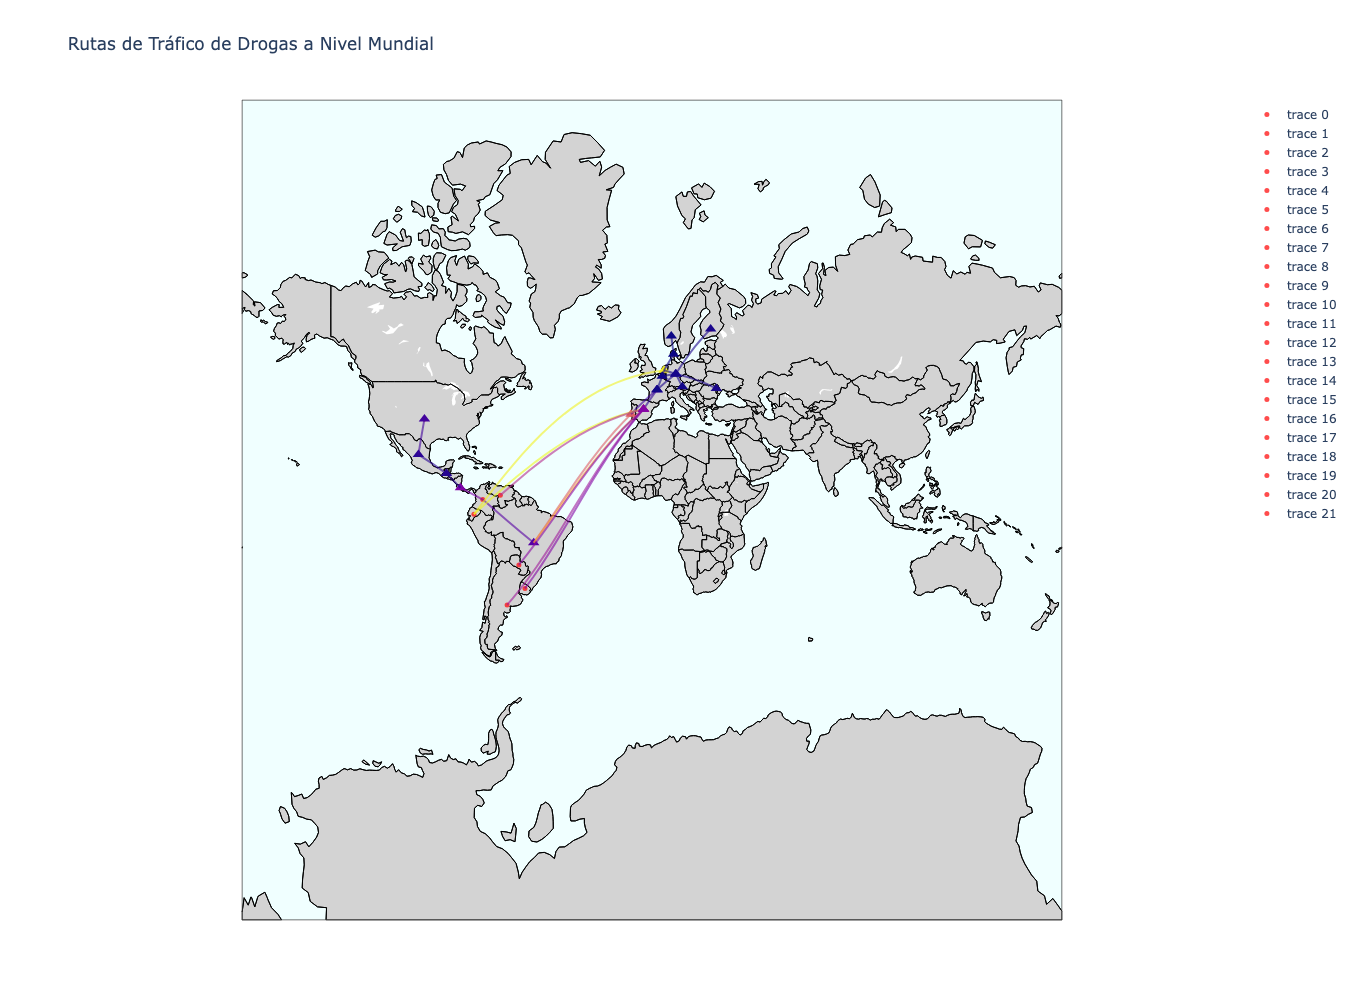

In [211]:
import plotly.graph_objects as go

# Función para convertir RGBA a RGB
def rgba_to_rgb(rgba):
    return f'rgba({int(rgba[0] * 255)}, {int(rgba[1] * 255)}, {int(rgba[2] * 255)}, {rgba[3]})'

fig = go.Figure()

# Agregar nodos (países) al gráfico
for node, coords in coordenadas_paises.items():
    fig.add_trace(go.Scattergeo(
        lon=[coords[0]], lat=[coords[1]], text=node, mode='markers', 
        marker=dict(size=5, color='red', opacity=0.7)
    ))

# Agregar rutas (flechas) entre los países
for u, v, data in G.edges(data=True):
    x_values = [pos[u][0], pos[v][0]]
    y_values = [pos[u][1], pos[v][1]]
    
    # Convertir la ponderación a color
    color_rgba = plt.cm.plasma(data['weight'] / max_weight)
    color = rgba_to_rgb(color_rgba)
    
    # Agregar línea entre los países
    fig.add_trace(go.Scattergeo(
        lon=x_values, lat=y_values, mode='lines', 
        line=dict(width=2, color=color, dash='solid'),
        opacity=0.6, showlegend=False,
        hoverinfo="text", hovertext=f"{u} -> {v}<br>Tráfico (u$s): {data['weight']:.2f}"
    ))
    
    # Agregar símbolo (flecha) al final de la ruta
    fig.add_trace(go.Scattergeo(
        lon=[x_values[1]], lat=[y_values[1]], mode='markers',
        marker=dict(symbol='triangle-up', size=10, color=color),
        opacity=1.0, showlegend=False,
        hoverinfo="text", hovertext=f"Tráfico % aumento: {data['weight']:.2f}"
    ))

# Configurar el layout del gráfico
fig.update_layout(
    geo=dict(
        projection_type='mercator',
        showland=True, landcolor="lightgrey", showocean=True, oceancolor="azure",
        showcountries=True, countrycolor="black", showcoastlines=True, coastlinecolor="black"
    ),
    title="Rutas de Tráfico de Drogas a Nivel Mundial",
    coloraxis_colorbar=dict(title="Magnitud del Tráfico (en toneladas)"),
    height=1000, width=1500
)

fig.show()
